In [1]:
import os
import pickle
from pathlib import Path
import subprocess
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import ExactMolWt
import pubchempy as pcp

import ms_pred.common as common
from ms_pred.retrieval.retrieval_benchmark import cos_dist_bin as cos_dist


/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /home/runzhong/ms-pred

/mnt/home/runzhong/ms-pred


In [3]:
conda_path = '/home/runzhong/mambaforge/bin/mamba'
python_path = '/home/runzhong/mambaforge/envs/ms-main/bin/python'
pubchem_form_map = 'data/retrieval/pubchem/pubchem_formula_map.p'
spec_dir = Path('data/elucidation/broad_distress/spec_files')
label_path = 'data/elucidation/broad_distress/cands_df_broad_distress.tsv'
label_per_cmpd_dir = Path('data/elucidation/broad_distress/labels')
gen_ckpt = 'results_ce_and_neg_bkup/dag_nist20/split_1_rnd1/version_0/best.ckpt'
# inten_ckpt = 'results_ce_and_neg_bkup/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt'
inten_ckpt = 'results_ce_and_neg/dag_inten_nist20/split_1_rnd1/version_19/best.ckpt'
save_dir = Path('/home/runzhong/ms_collaborators/broad_ms_share/distress/result')


# Preprocessing & Prepare Candidates

In [4]:
df_label = pd.read_csv('/home/runzhong/ms_collaborators/broad_ms_share/distress/HILIC-pos/HILIC-pos_mapping_MSMS.csv')
df_label = df_label[df_label["Metabolite"].notnull() | df_label["Of Interest"] == True]
df_label[df_label["Metabolite"].notnull()]
# df_label[df_label['Compound_ID'] == 'QI8447']

,Method,Compound_ID,MZ_MSMS,RT_MSMS,Metabolite,Of Interest
0,HILIC-pos,QI8400,130.086064,8.630833,N-Methyl-proline,True
557,HILIC-pos,QI6067,126.136274,7.374167,Valine-d8 [iSTD],NaN
558,HILIC-pos,QI6628,137.070741,8.203217,1-Methyl nicotinamide,NaN
559,HILIC-pos,QI6299,282.119318,7.622883,1-Methyladenosine,NaN
560,HILIC-pos,QI4293,166.072152,5.127000,1-Methylguanine,NaN
...,...,...,...,...,...,...
754,HILIC-pos,QI3755,139.050040,4.503033,Urocanic acid,NaN
755,HILIC-pos,QI1339,436.233900,1.802083,Valsartan,NaN
756,HILIC-pos,QI4944,455.290162,5.681167,Verapamil,NaN
757,HILIC-pos,QI1158,309.111767,1.736633,Warfarin,NaN


In [75]:
# Delete non-interested entries
for spec in spec_dir.glob('*.ms'):
    if spec.stem not in df_label["Compound_ID"].values:
        os.remove(spec)
        print(f'deleted {spec}')

In [6]:
# Call SIRIUS to generate candidates
cmd = f"""{conda_path} run -n ms-main \\
    python data_scripts/deploy/broad_candidates_from_ms.py \\
    --pickle-file {pubchem_form_map}  \\
    --spec-dir {spec_dir} \\
    """
print(cmd + "\n")
subprocess.run(cmd, shell=True)

/home/runzhong/mambaforge/bin/mamba run -n ms-main \
    python data_scripts/deploy/broad_candidates_from_ms.py \
    --pickle-file data/retrieval/pubchem/pubchem_formula_map.p  \
    --spec-dir data/elucidation/broad_distress/spec_files \
    



CondaError: KeyboardInterrupt



KeyboardInterrupt: 

In [77]:
# Get separate labels for each spectrum
label_per_cmpd_dir.mkdir(exist_ok=True)
cands_label = pd.read_csv(label_path, sep='\t')

for spec_name in tqdm(cands_label["spec"].unique()):
    sub_df = cands_label[cands_label["spec"] == spec_name]
    sub_df.to_csv(label_per_cmpd_dir / f'cands_df_{spec_name}.tsv', sep='\t')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 661/661 [02:00<00:00,  5.48it/s]


## Predict spectrum for candidates

Citrulline NC(=O)NCCCC(N)C(=O)O


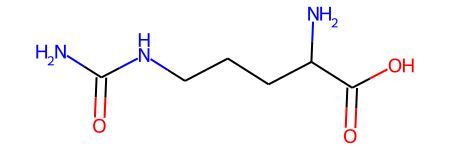

In [13]:
spec_of_interest = "QI8508"

# Successful cases:
# 'TF17', 'QI8508', 'QI10780', 'QI8239', 'QI10996', 'QI8447', 'QI6299', 'QI9230', 'QI8495', 'QI10716', 'QI3350', 'QI12168'

# Failure cases:
# 'TF12', 'QI5853', 'QI8969', 'QI6919', 'QI9902', 'QI6400', 'QI4297', 'QI8197', 'QI9684', 'QI9802'
# Wrong formula 'QI4092'

# Get the ground truth (if exist)
row = df_label[df_label['Compound_ID'] == spec_of_interest]
target_name = row["Metabolite"].values[0]
precursor_mz = row["MZ_MSMS"].values[0]

compounds = pcp.get_compounds(target_name, 'name')
if len(compounds) == 0:
    print(f'No match in PubChem for {spec_of_interest}')
    target_mol = target_inchikey = None
else:
    target_mol = [Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(comp.isomeric_smiles), isomericSmiles=False)) for comp in compounds]
    target_inchikey = [Chem.MolToInchiKey(mol) for mol in target_mol]

print(target_name, Chem.MolToSmiles(target_mol[0]))
target_mol[0]

In [14]:
# max-nodes = 20 for fewer peaks in CID
cmd = (f'''{python_path} src/ms_pred/dag_pred/predict_smis.py \\
       --num-workers 64 \\
       --dataset-labels {label_per_cmpd_dir / f"cands_df_{spec_of_interest}.tsv"} \\
       --sparse-out \\
       --sparse-k 100 \\
       --max-nodes 20 \\
       --threshold 0.1 \\
       --gen-checkpoint {gen_ckpt} \\
       --inten-checkpoint {inten_ckpt} \\
       --save-dir {save_dir / spec_of_interest} \\
       --binned-out \\
       --adduct-shift''')
print(cmd)
subprocess.run(cmd, shell=True)

/home/runzhong/mambaforge/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
       --num-workers 64 \
       --dataset-labels data/elucidation/broad_distress/labels/cands_df_QI8508.tsv \
       --sparse-out \
       --sparse-k 100 \
       --max-nodes 20 \
       --threshold 0.1 \
       --gen-checkpoint results_ce_and_neg_bkup/dag_nist20/split_1_rnd1/version_0/best.ckpt \
       --inten-checkpoint results_ce_and_neg/dag_inten_nist20/split_1_rnd1/version_19/best.ckpt \
       --save-dir /home/runzhong/ms_collaborators/broad_ms_share/distress/result/QI8508 \
       --binned-out \
       --adduct-shift


/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/pytorch_lightning/utilities/seed.py:55: UserWarning: No seed found, seed set to 1168015640
  rank_zero_warn(f"No seed found, seed set to {seed}")
Global seed set to 1168015640


2024-05-08 15:57:36,007 INFO: 
adduct_shift: true
batch_size: 64
binned_out: true
dataset_labels: data/elucidation/broad_distress/labels/cands_df_QI8508.tsv
dataset_name: null
debug: false
gen_checkpoint: results_ce_and_neg_bkup/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: false
inten_checkpoint: results_ce_and_neg/dag_inten_nist20/split_1_rnd1/version_19/best.ckpt
max_nodes: 20
num_bins: 15000
num_workers: 64
save_dir: /home/runzhong/ms_collaborators/broad_ms_share/distress/result/QI8508
sparse_k: 100
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.1
upper_limit: 1500
2024-05-08 15:57:36,716 INFO: Loaded gen / inten models from results_ce_and_neg_bkup/dag_nist20/split_1_rnd1/version_0/best.ckpt & results_ce_and_neg/dag_inten_nist20/split_1_rnd1/version_19/best.ckpt


100%|██████████| 514/514 [03:59<00:00,  2.15it/s]

2024-05-08 16:01:39,094 INFO: Program finished in: 243.09872126579285 seconds


CompletedProcess(args='/home/runzhong/mambaforge/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \\\n       --num-workers 64 \\\n       --dataset-labels data/elucidation/broad_distress/labels/cands_df_QI8508.tsv \\\n       --sparse-out \\\n       --sparse-k 100 \\\n       --max-nodes 20 \\\n       --threshold 0.1 \\\n       --gen-checkpoint results_ce_and_neg_bkup/dag_nist20/split_1_rnd1/version_0/best.ckpt \\\n       --inten-checkpoint results_ce_and_neg/dag_inten_nist20/split_1_rnd1/version_19/best.ckpt \\\n       --save-dir /home/runzhong/ms_collaborators/broad_ms_share/distress/result/QI8508 \\\n       --binned-out \\\n       --adduct-shift', returncode=0)

In [15]:
binned_preds = pickle.load(open(save_dir / spec_of_interest / 'binned_preds.p', 'rb'))

# Only for GABA-Arg
# real_spec_name = 'mxp4157'
# target_name = '2-amino-5-{4 [(diaminomethylidene)amino]butanamido}pentanoic acid'
# precursor_mz = 260.171715984
# real_smiles = r'O=C(O)C(N)CCCNC(CCC/N=C(N)\N)=O'
# target_inchikey = [Chem.MolToInchiKey(Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(real_smiles), isomericSmiles=False)))]

smiles = np.array(binned_preds['smiles'])
spec_names = np.array(binned_preds['spec_names'])
pred_specs = np.array(binned_preds['preds'])
num_bins = binned_preds['num_bins']
# meta, specs = common.parse_spectra(spec_dir / f'{real_spec_name}.ms')
meta, specs = common.parse_spectra(spec_dir / f'{spec_of_interest}.ms')
ref_spec = common.process_spec_file(meta, specs, merge_specs=False)
ref_binned = {common.get_collision_energy(k): common.bin_spectra([v], num_bins)[0] for k, v in ref_spec.items()}
dist = cos_dist(pred_specs, ref_binned, ignore_peak=(precursor_mz - 1) * 10)

[QI8508] Citrulline: Found true mol at 18/515, cos_dist=0.621


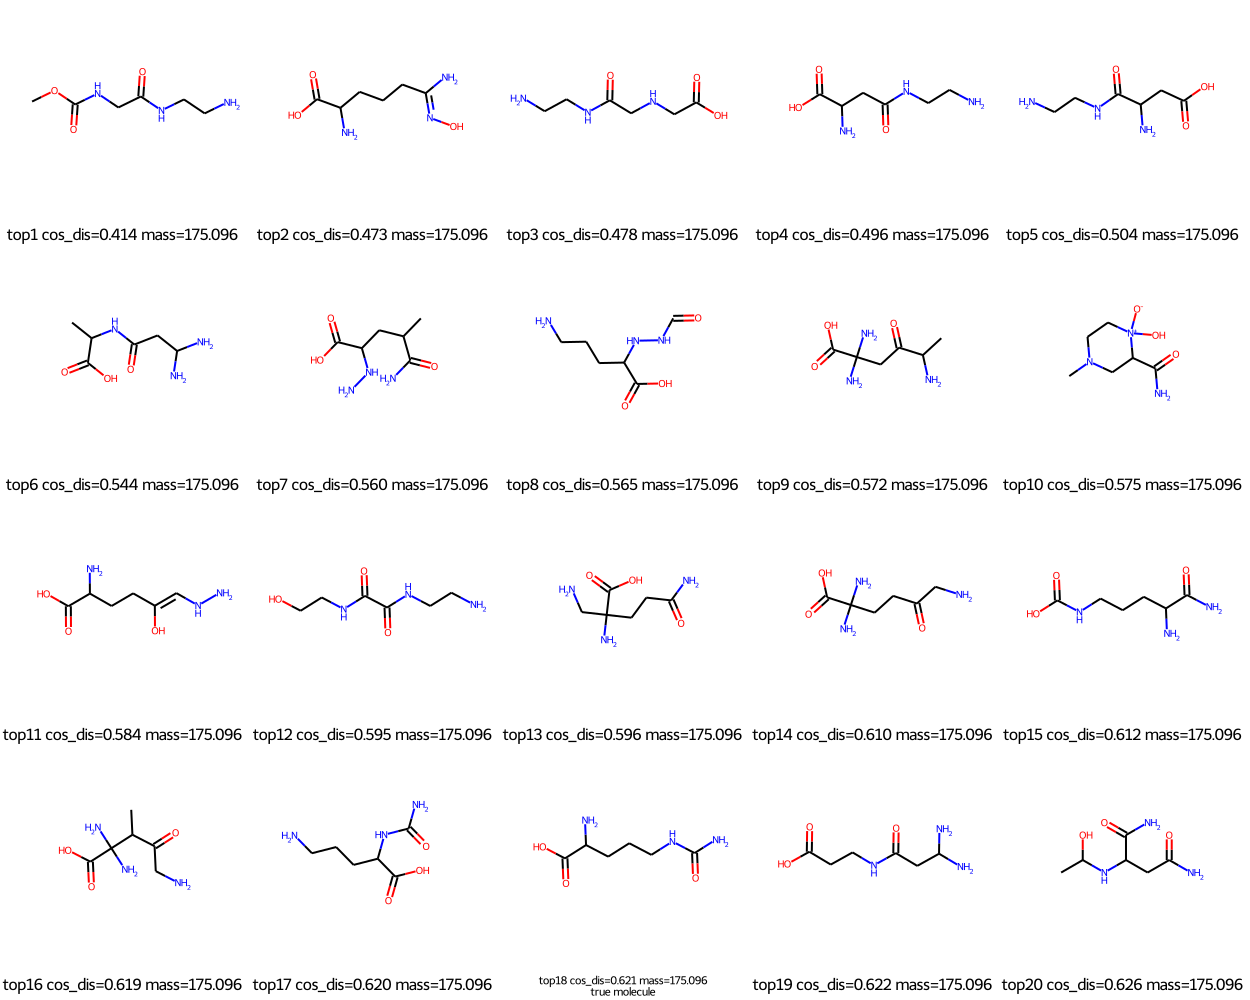

In [16]:
topk = 20
sorted_indices = np.argsort(dist) 

legends = []
found_true = False
true_idx = -1
for rnk, idx in enumerate(sorted_indices):
    d = dist[idx]
    smi = smiles[idx]
    inchikey = Chem.MolToInchiKey(Chem.MolFromSmiles(smi))
    legend = f"top{rnk+1} cos_dis={d:.3f} mass={common.mass_from_smi(smi):.3f}"
    if target_inchikey is not None and inchikey in target_inchikey:
        print(f'[{spec_of_interest}] {target_name}: Found true mol at {rnk+1}/{len(sorted_indices)+1}, cos_dist={d:.3f}')
        found_true = True
        true_idx = rnk
        legend += '\ntrue molecule'
    legends.append(legend)
    if len(legends) > topk and found_true:
        break
Draw.MolsToGridImage([Chem.MolFromSmiles(smiles[i]) for i in sorted_indices[:topk]], molsPerRow=5, subImgSize=(250,250), legends=legends[:topk])

num recall = 78


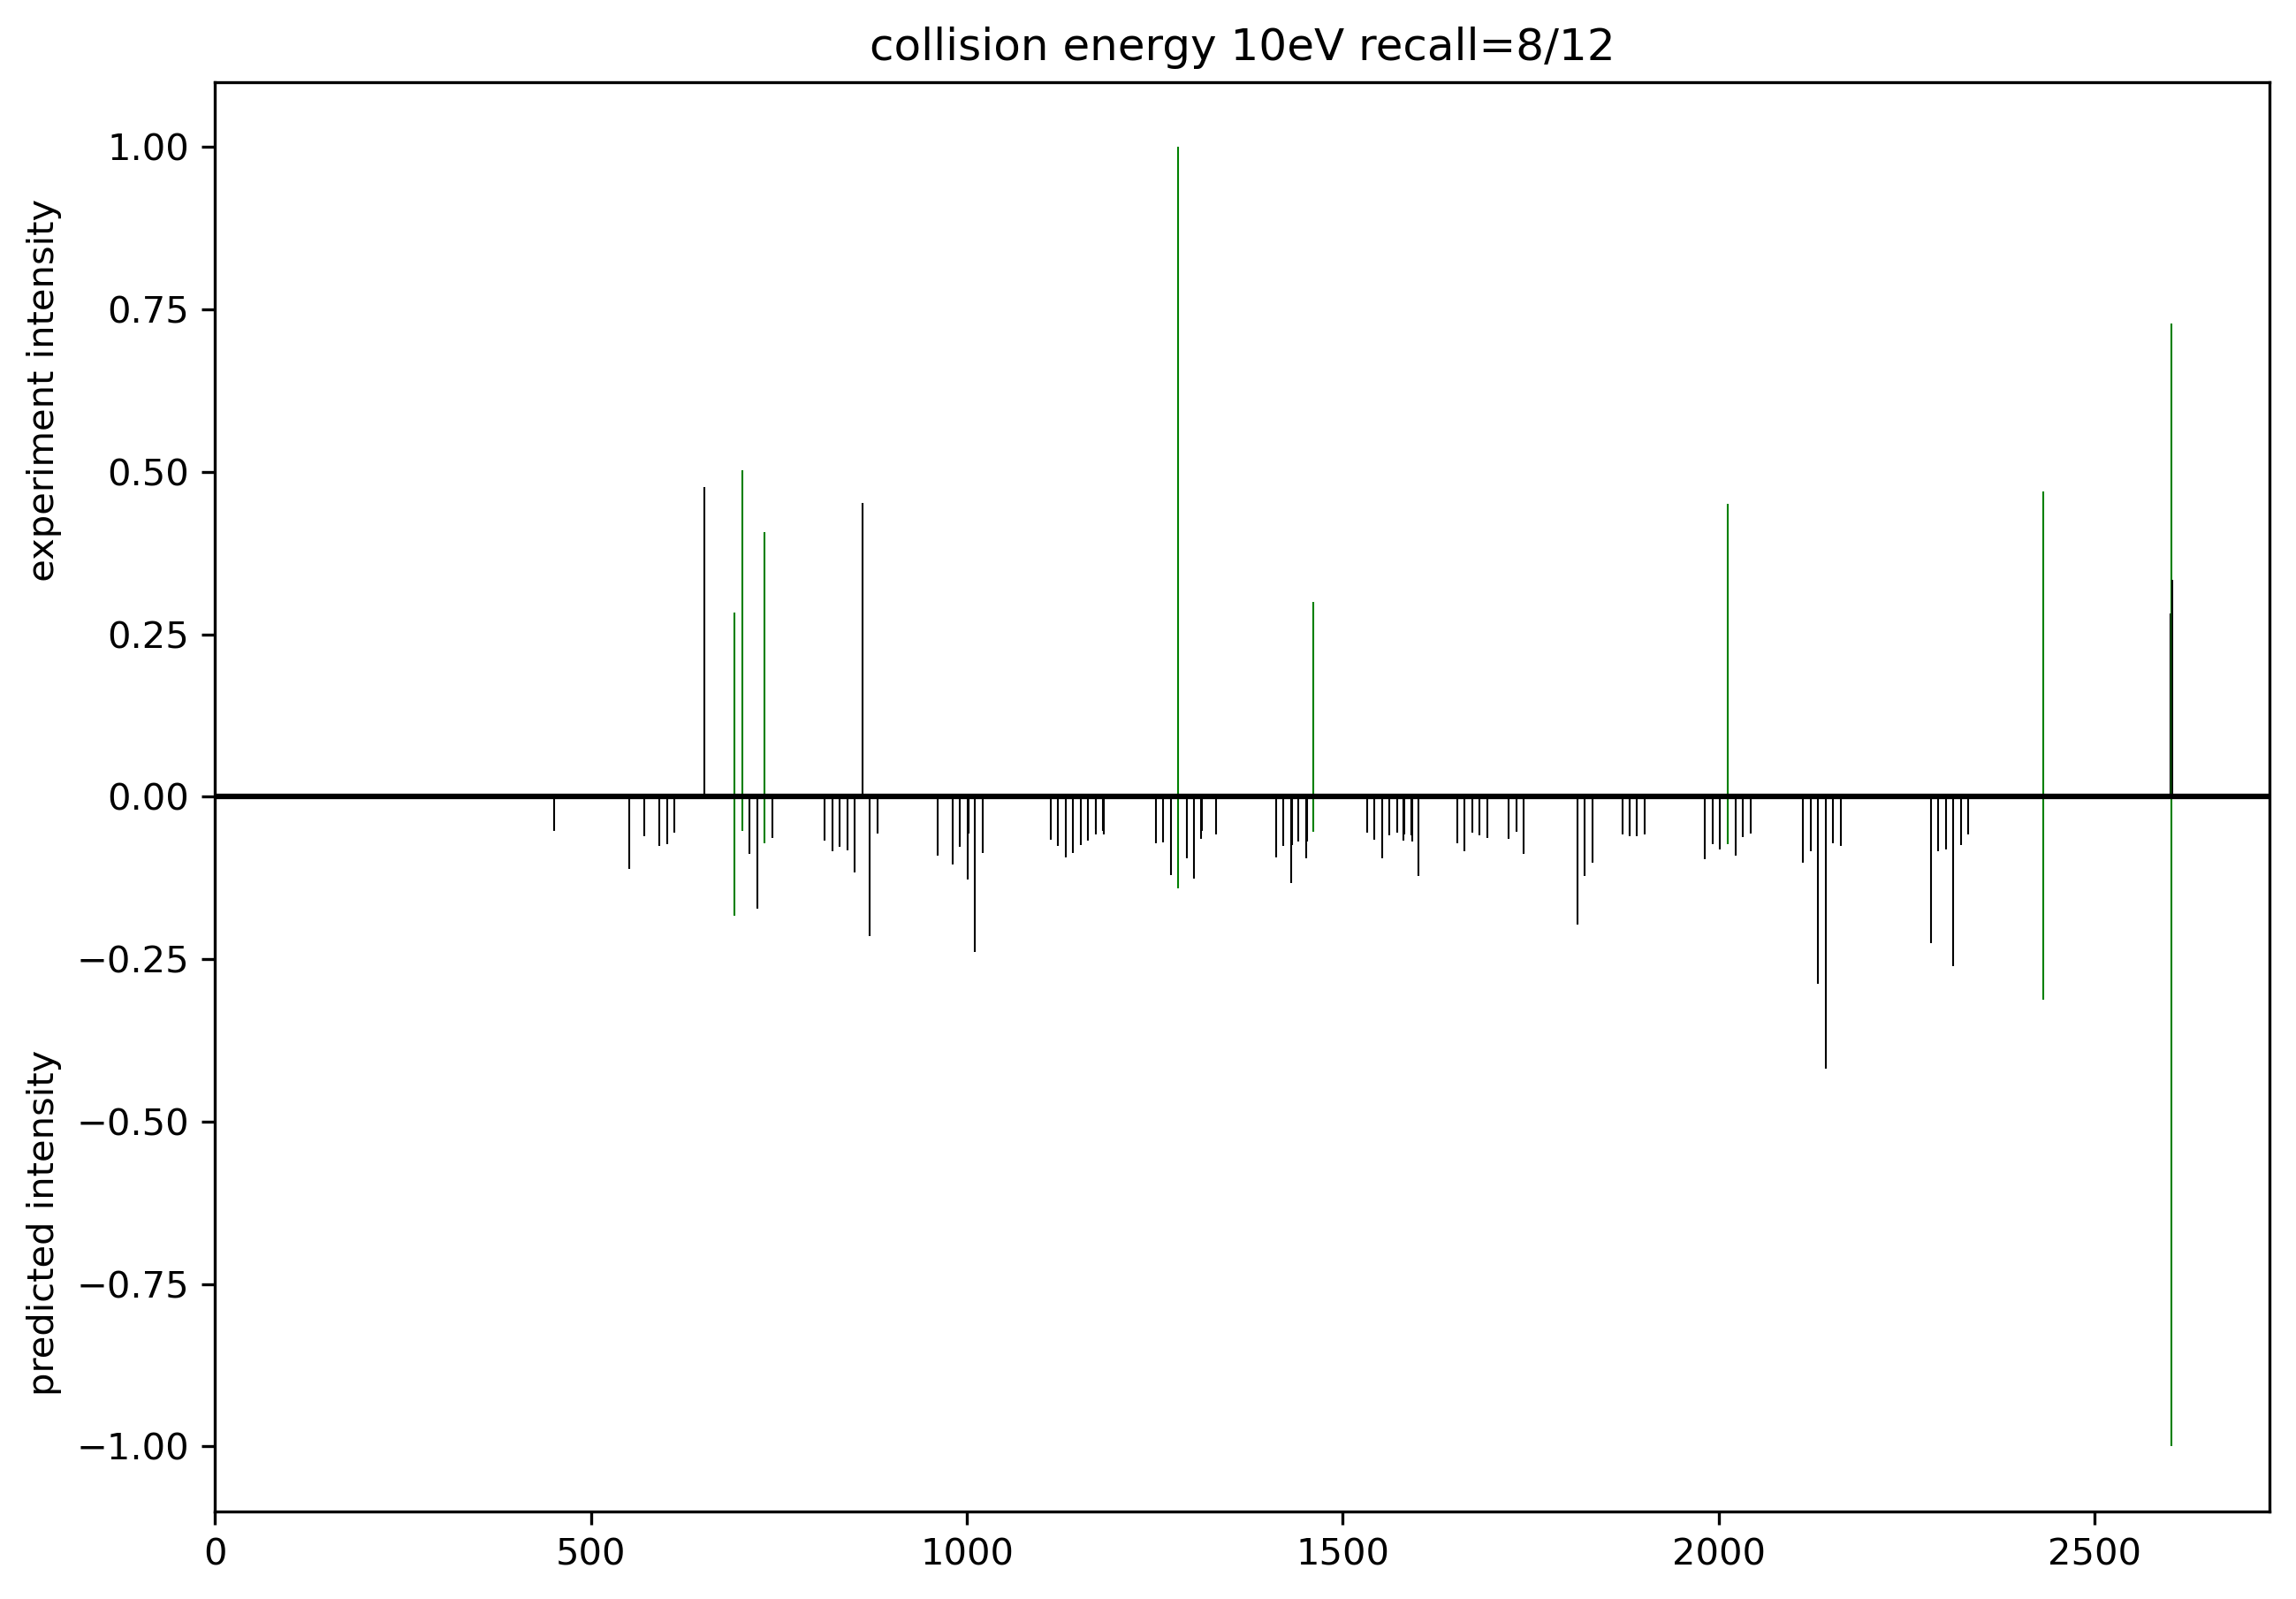

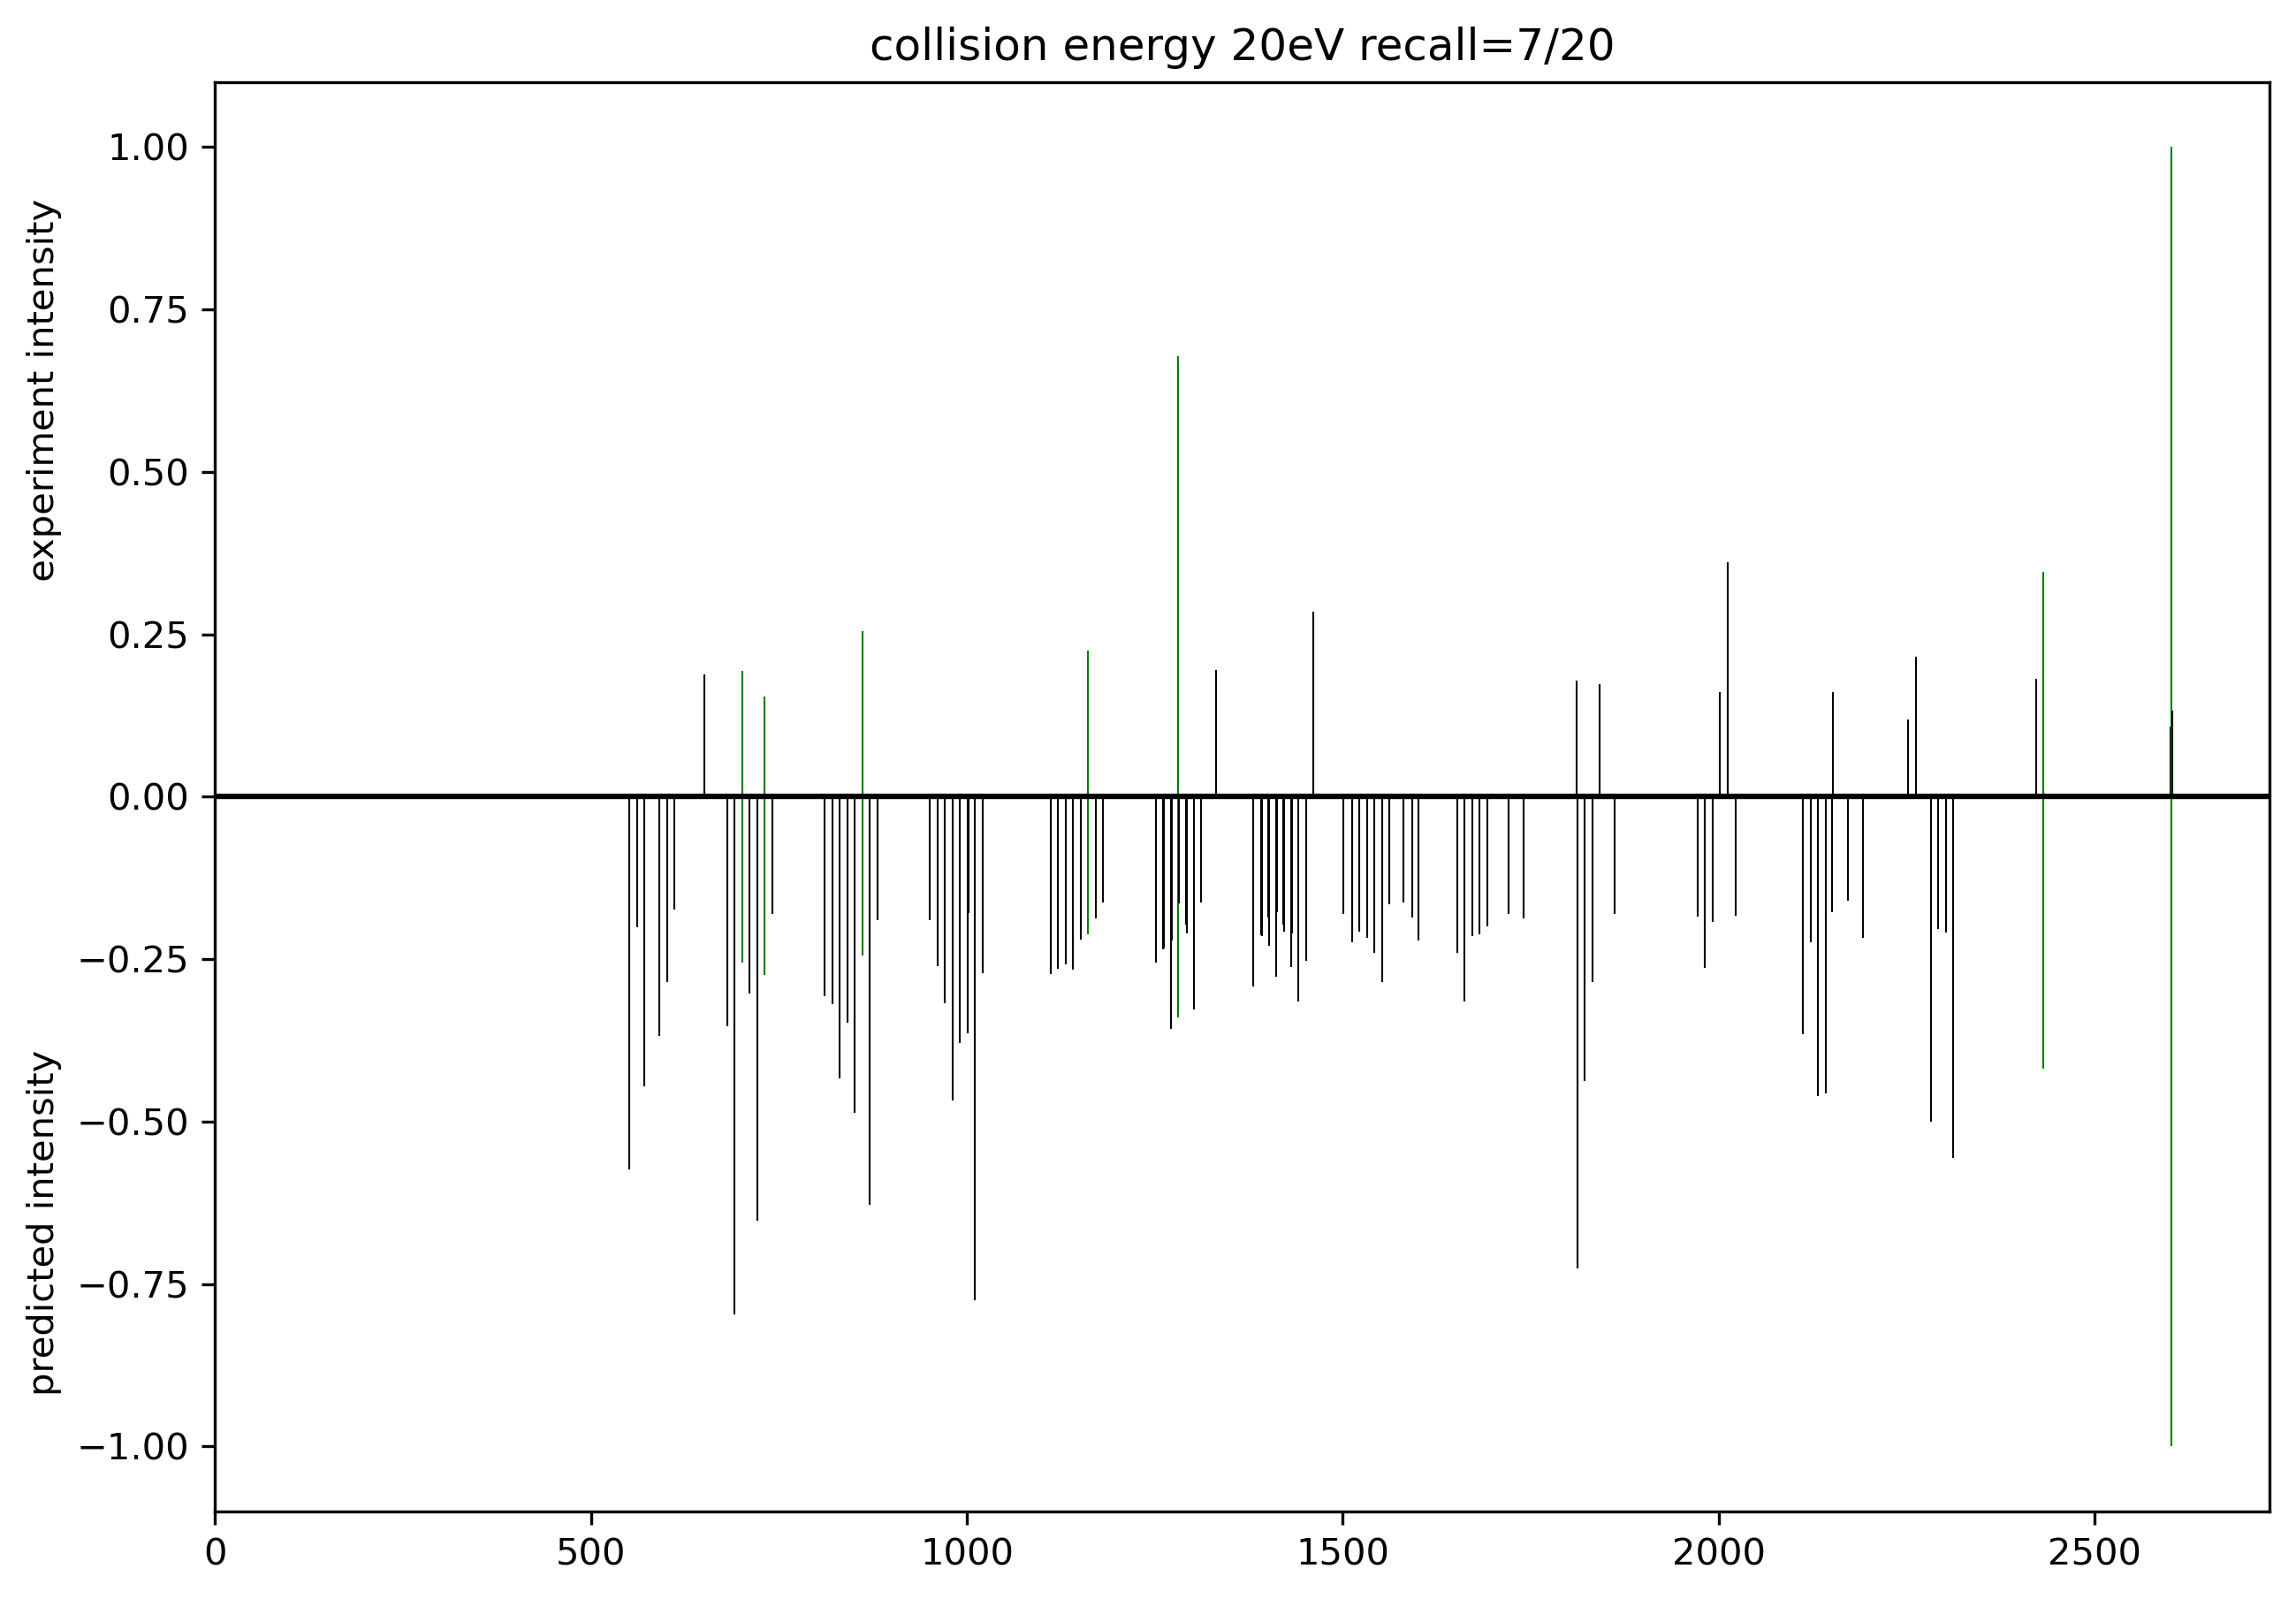

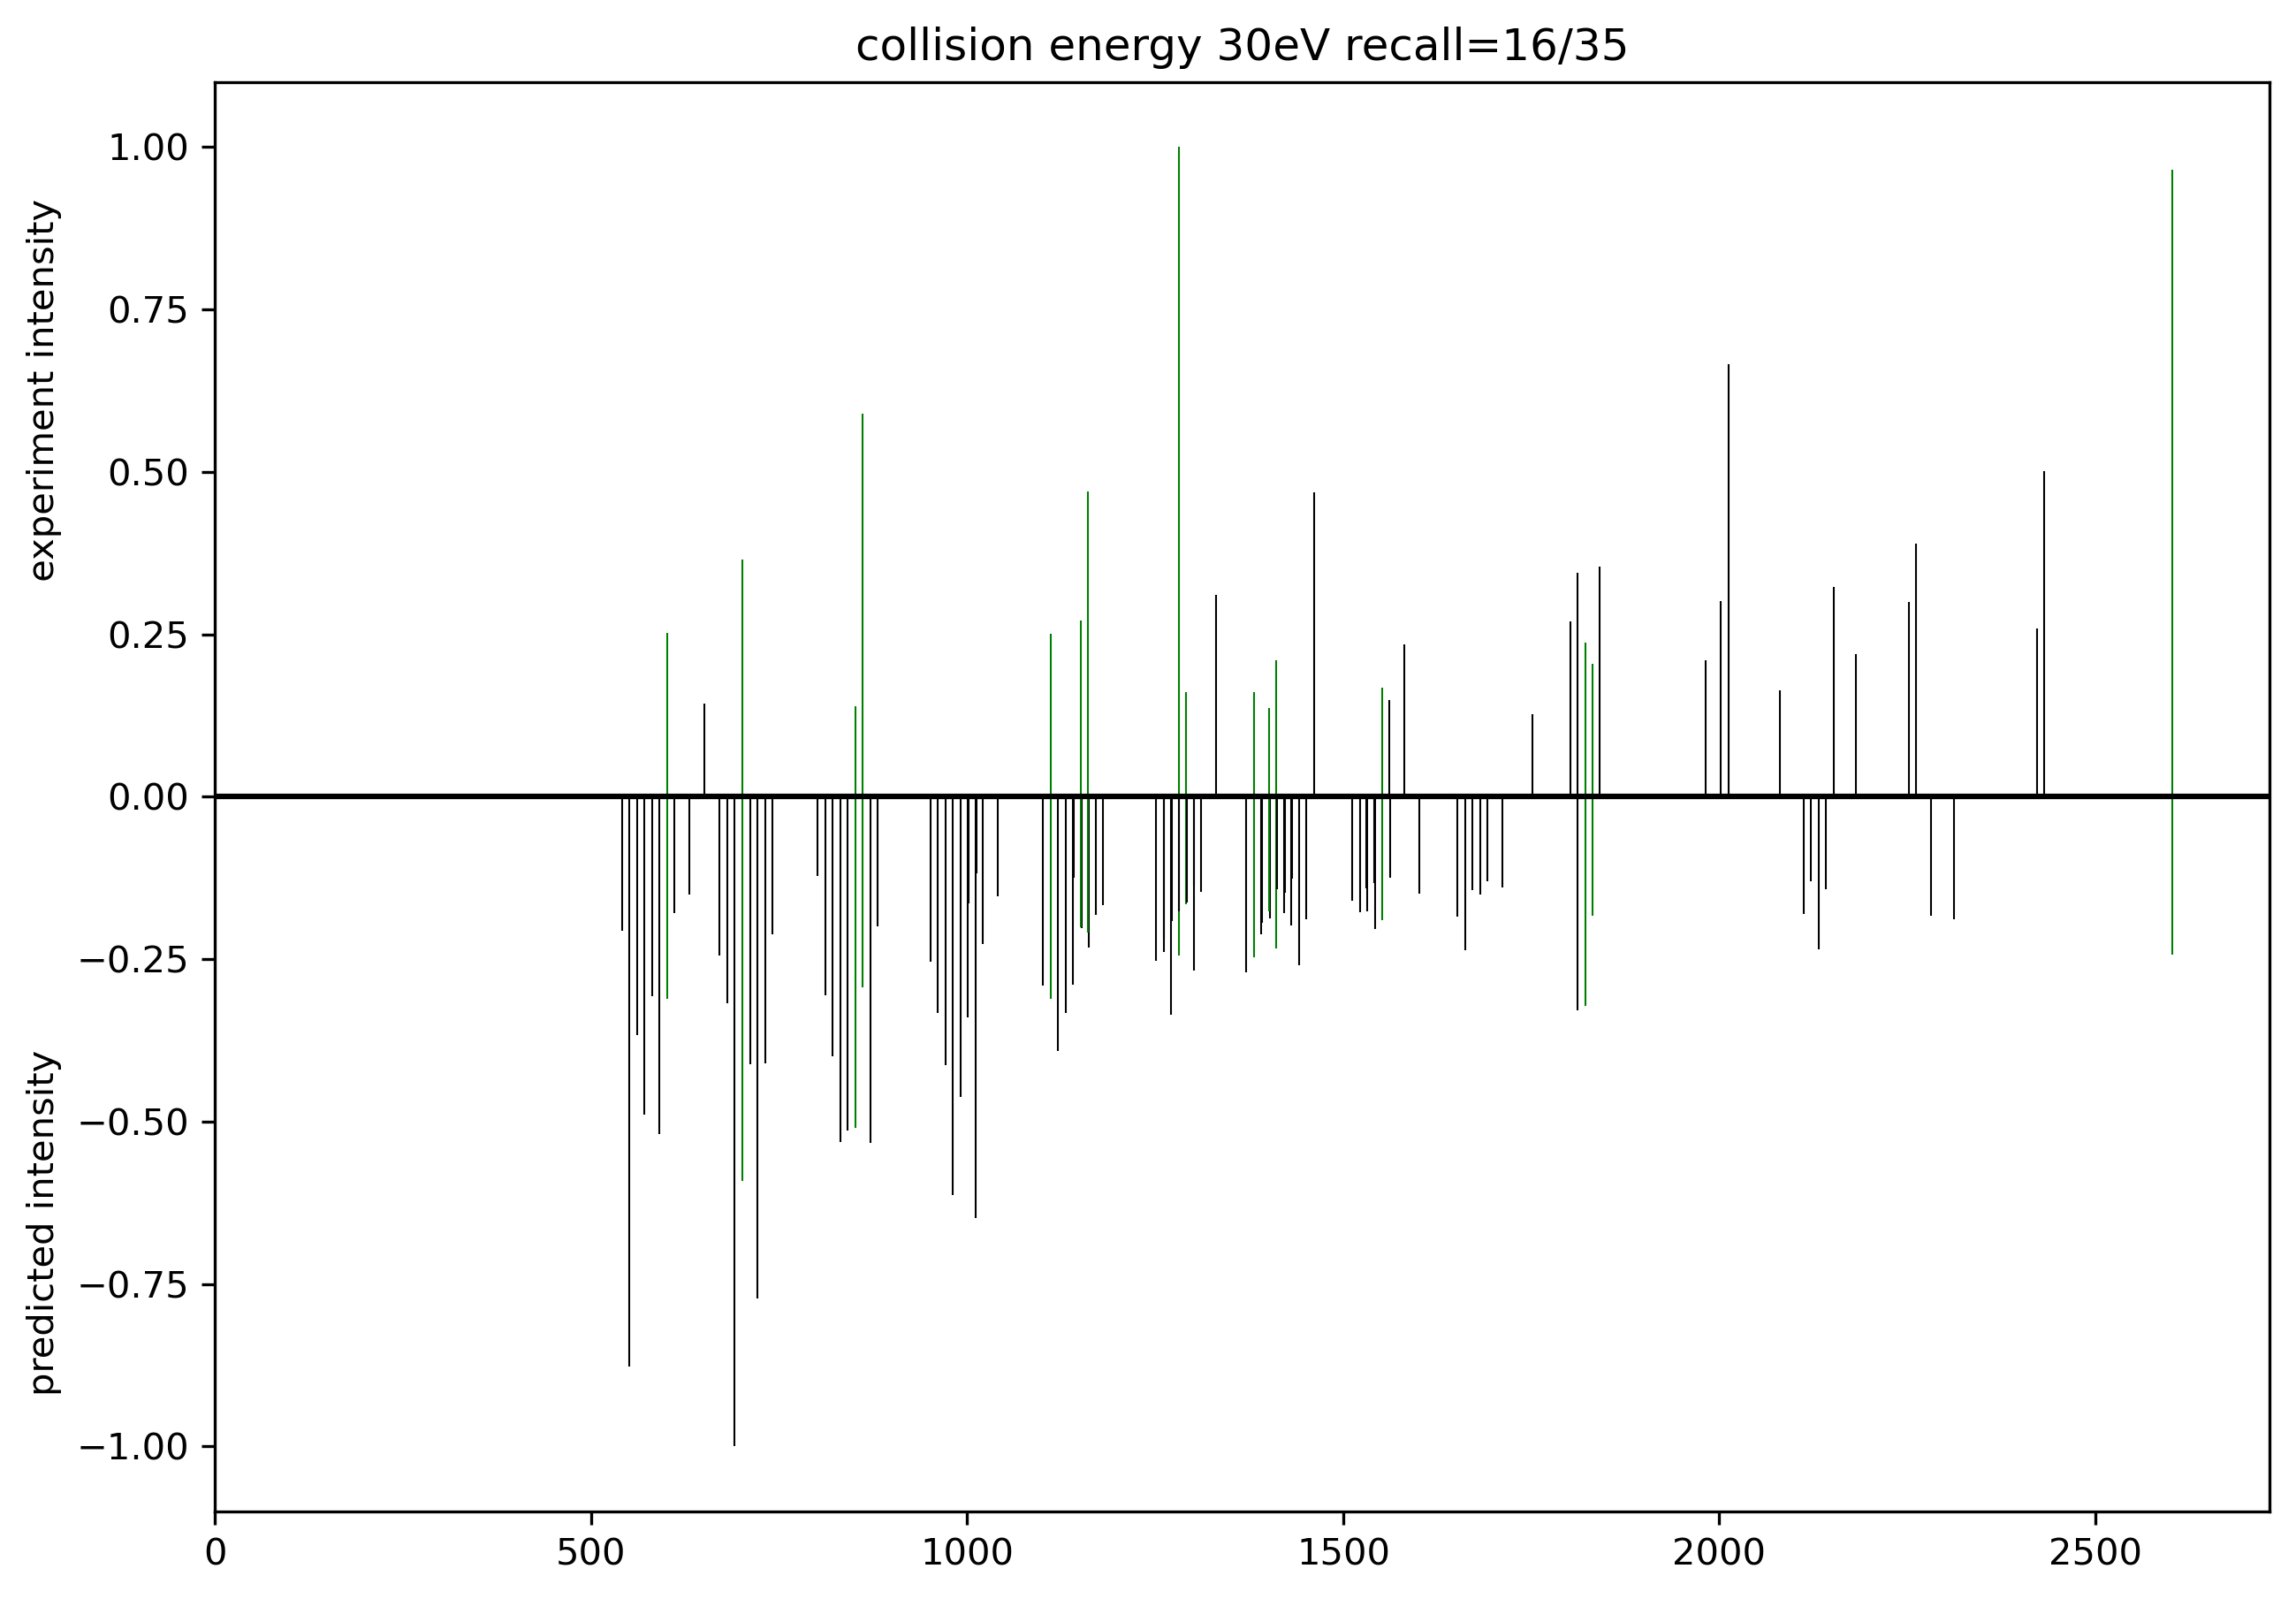

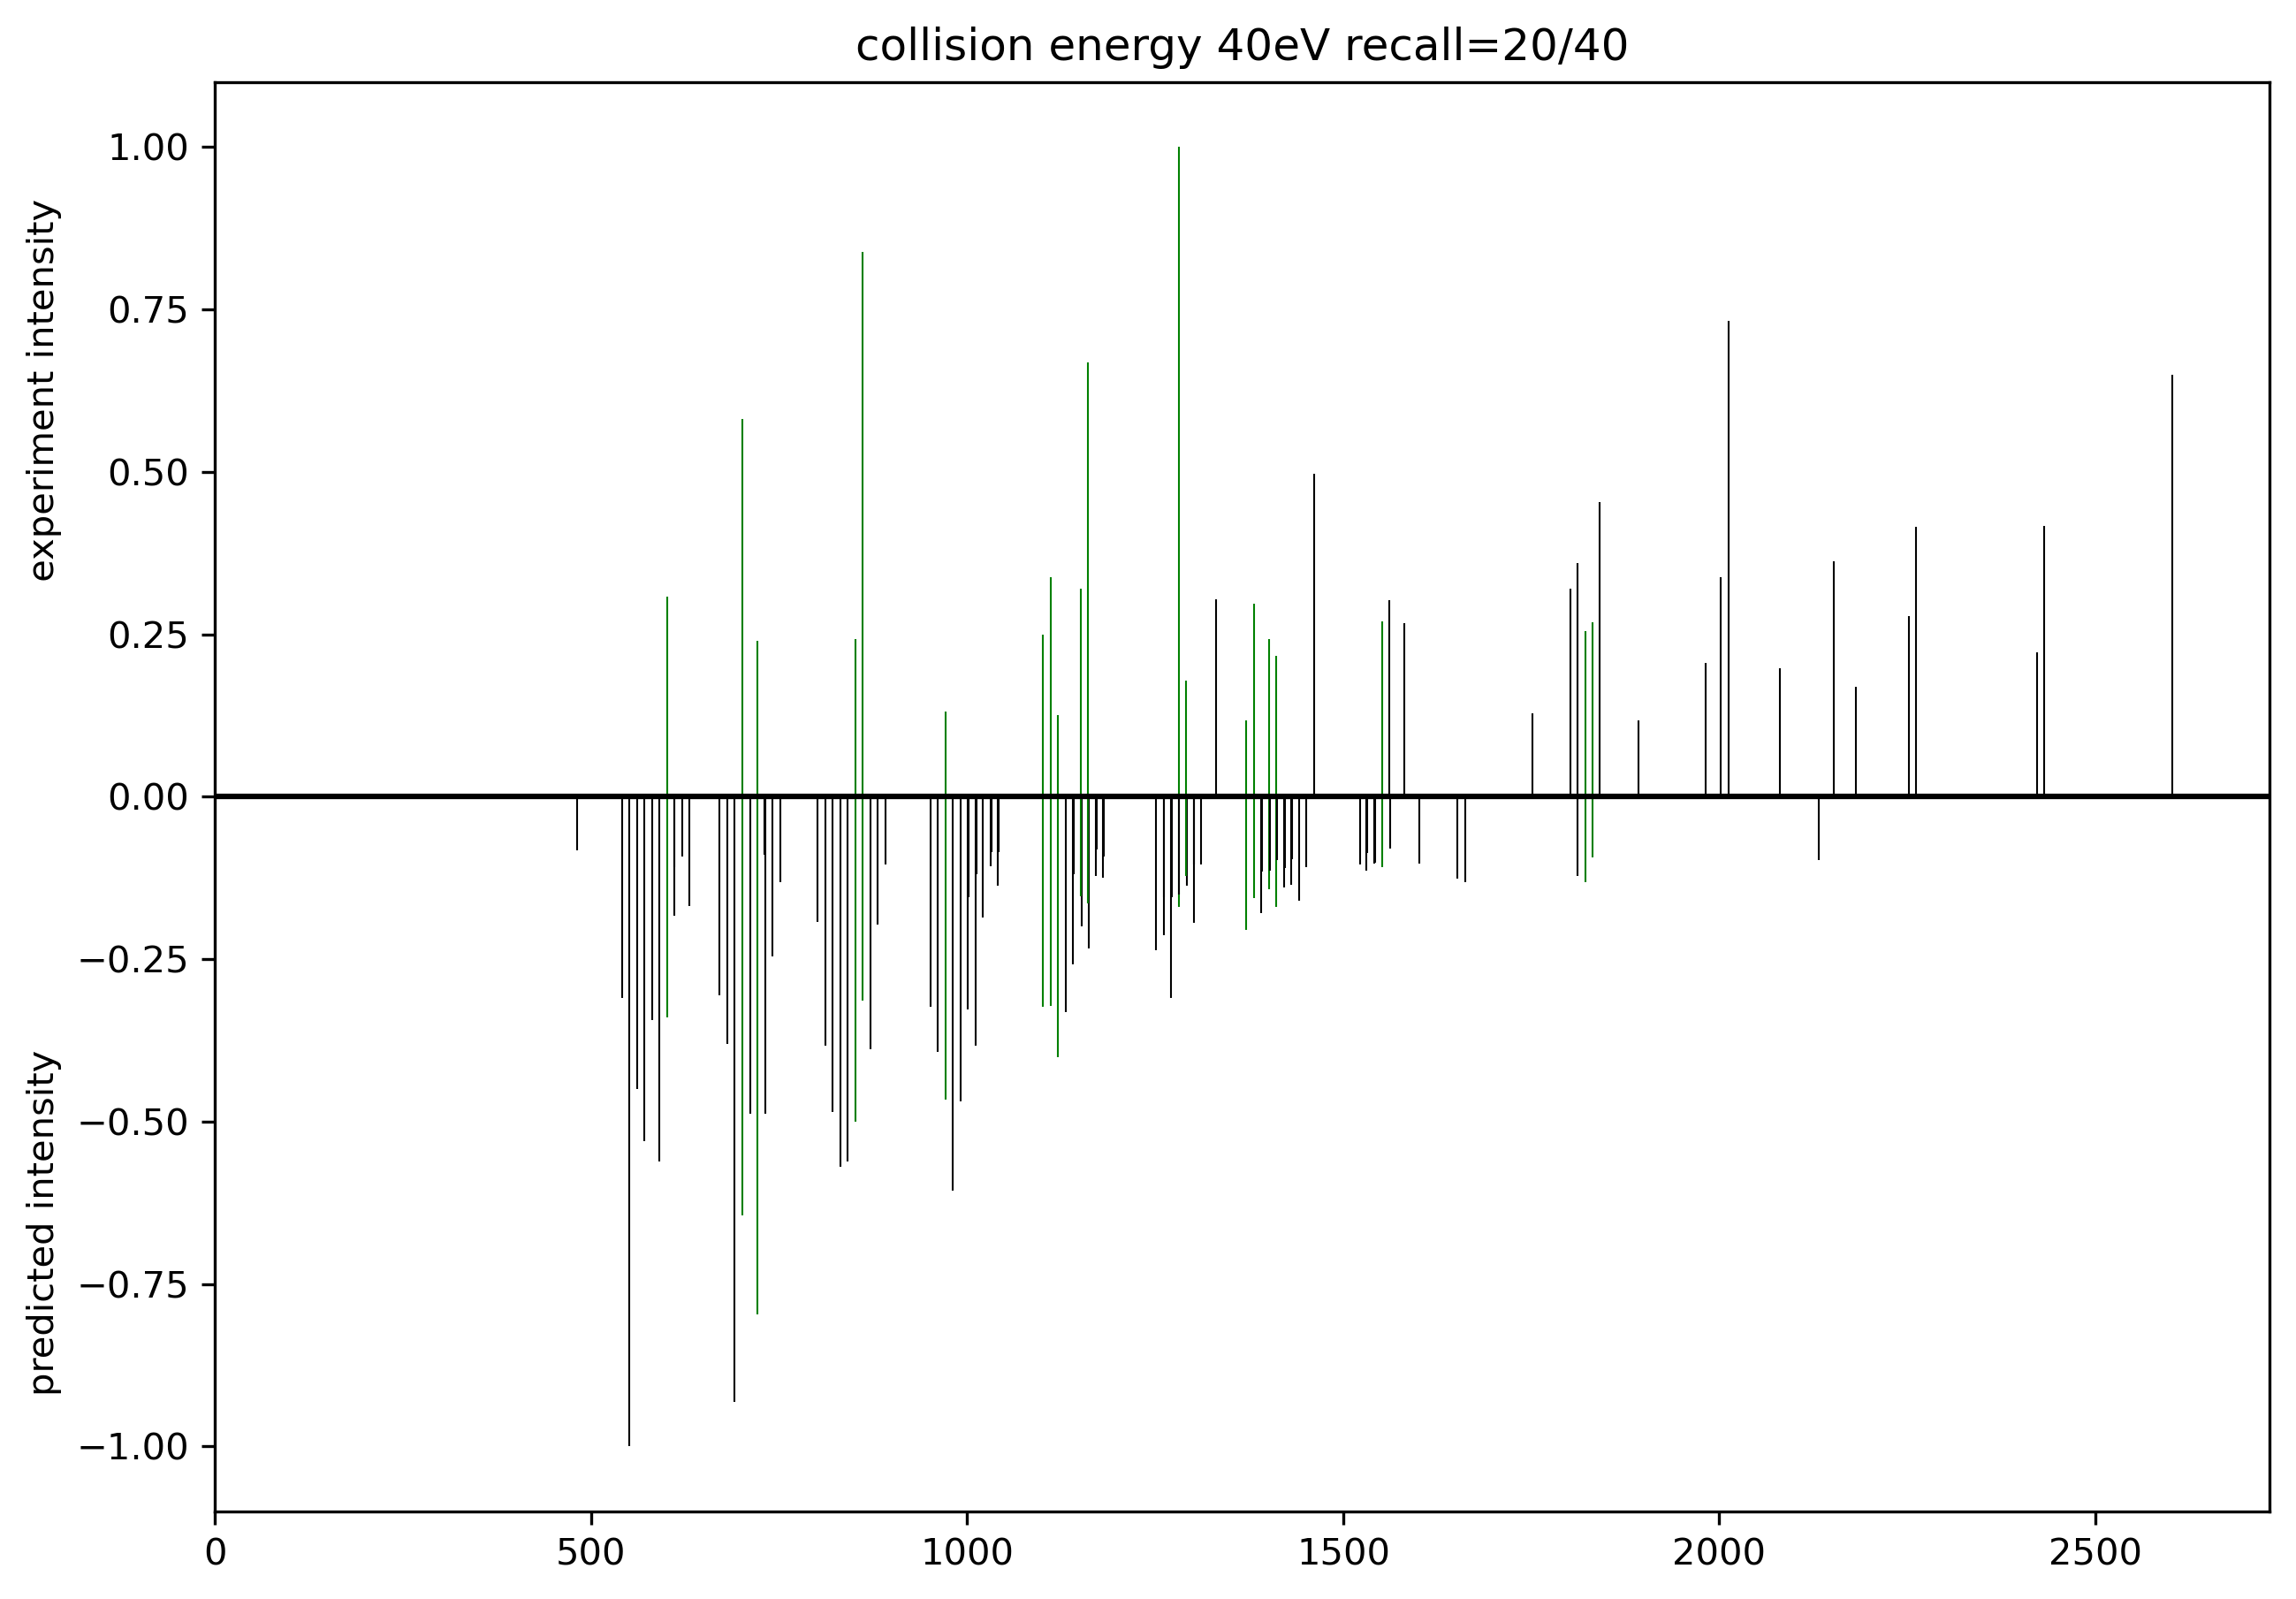

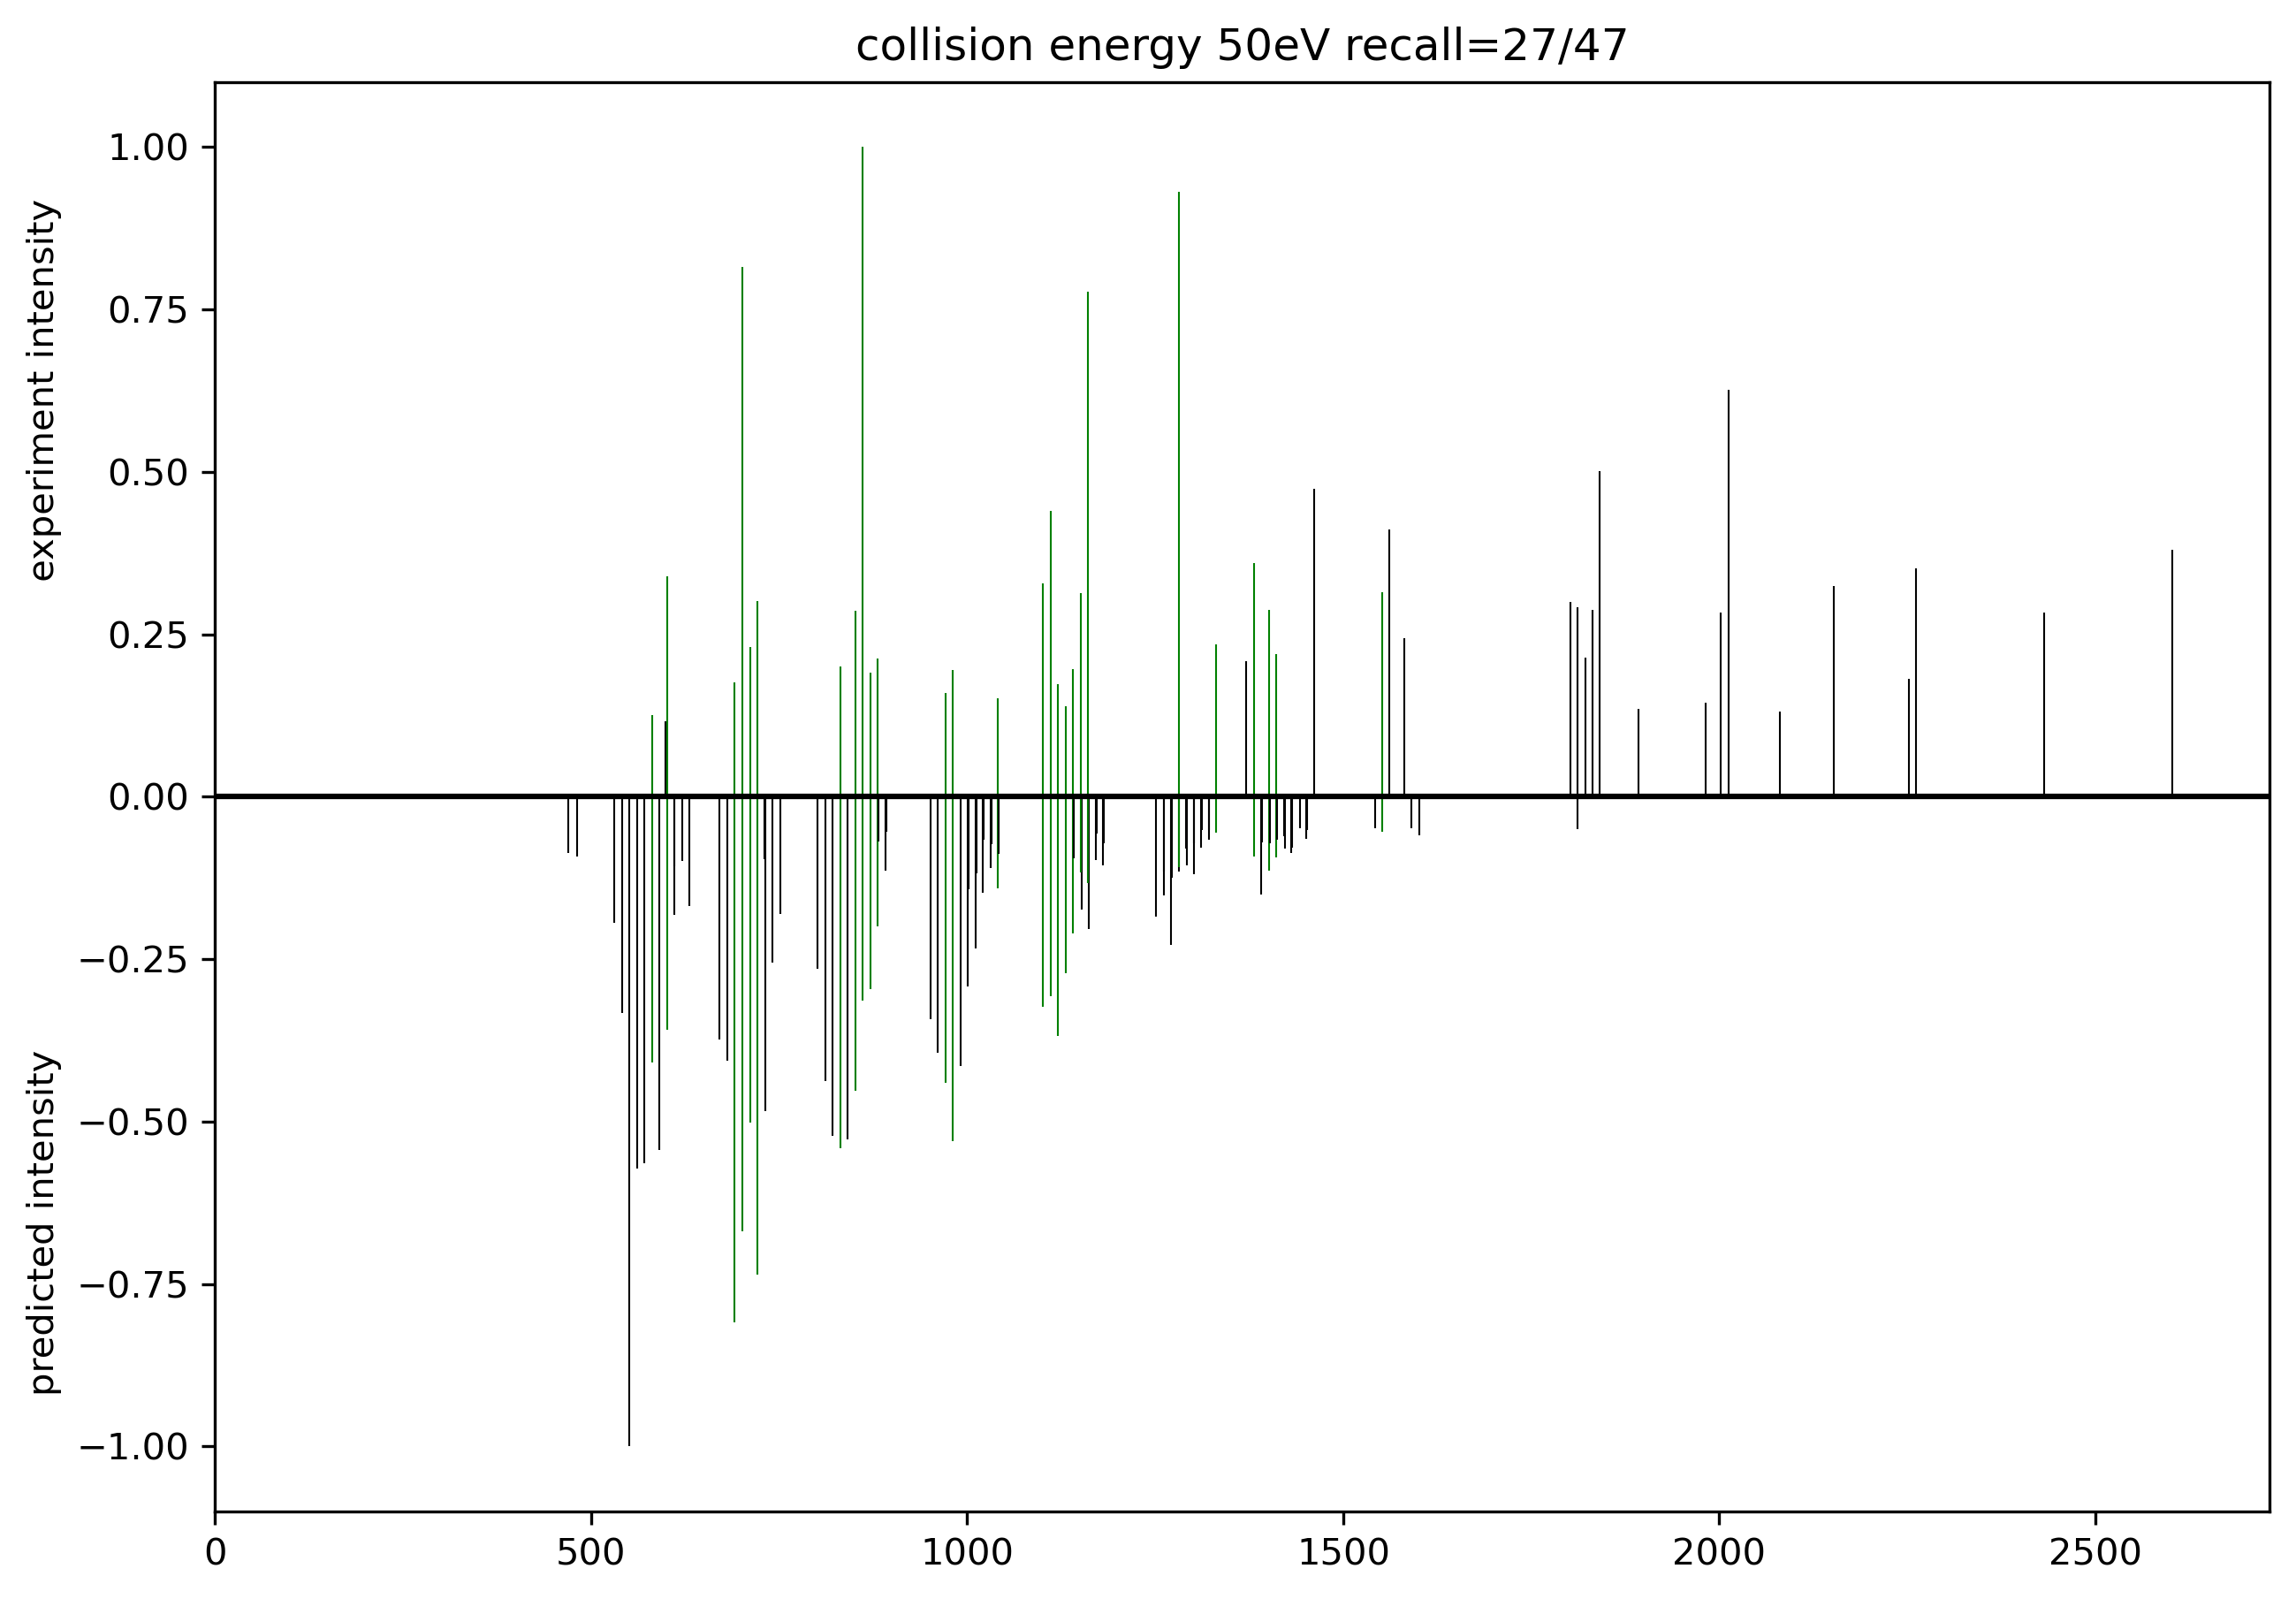

In [11]:
num_recall = 0
for ce in ref_binned.keys():
    ref_binned_sparse = np.vstack((np.where(ref_binned[ce] != 0), ref_binned[ce][np.where(ref_binned[ce] != 0)])).T
    pred_spec = pred_specs[true_idx][ce]
    n_recall = np.sum(ref_binned_sparse[:, 0][:, None] == pred_spec[:, 0][None, :])
    num_recall += n_recall
    common.plot_compare_ms(ref_binned_sparse, pred_spec, 'experiment', 'predicted',  f'collision energy {ce}eV recall={n_recall}/{ref_binned_sparse.shape[0]}')
print(f'num recall = {num_recall}')

num recall = 83


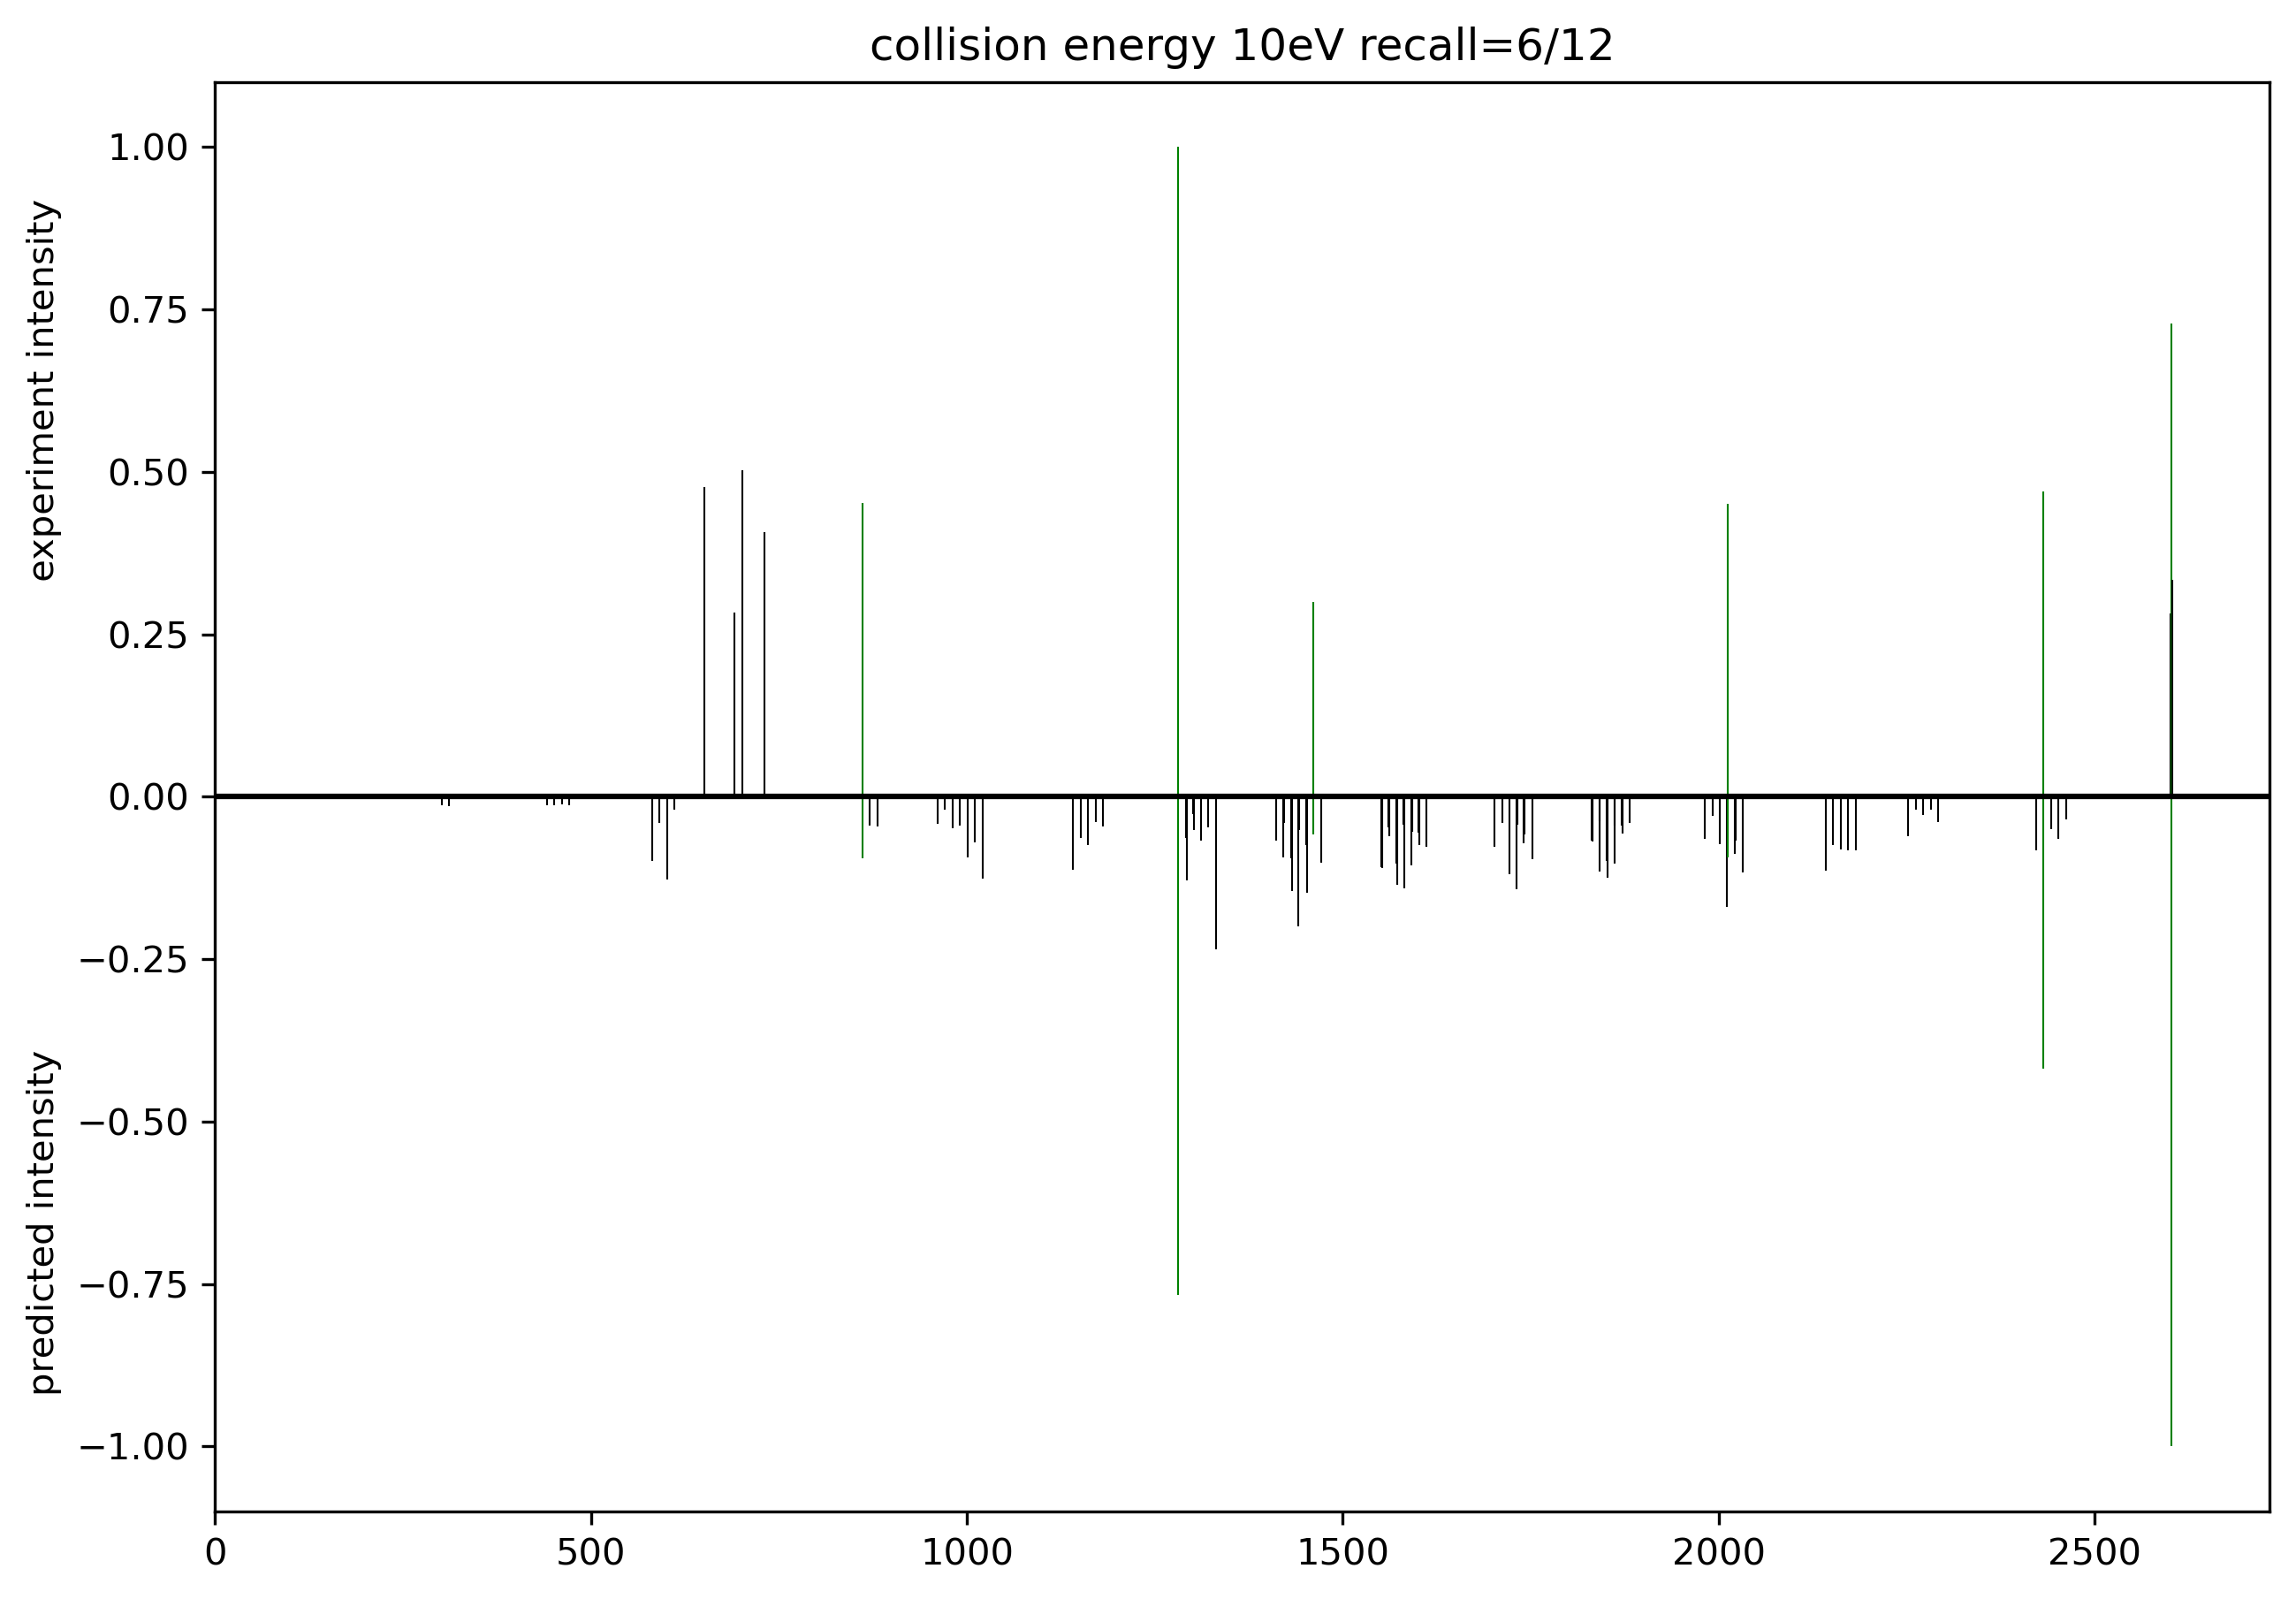

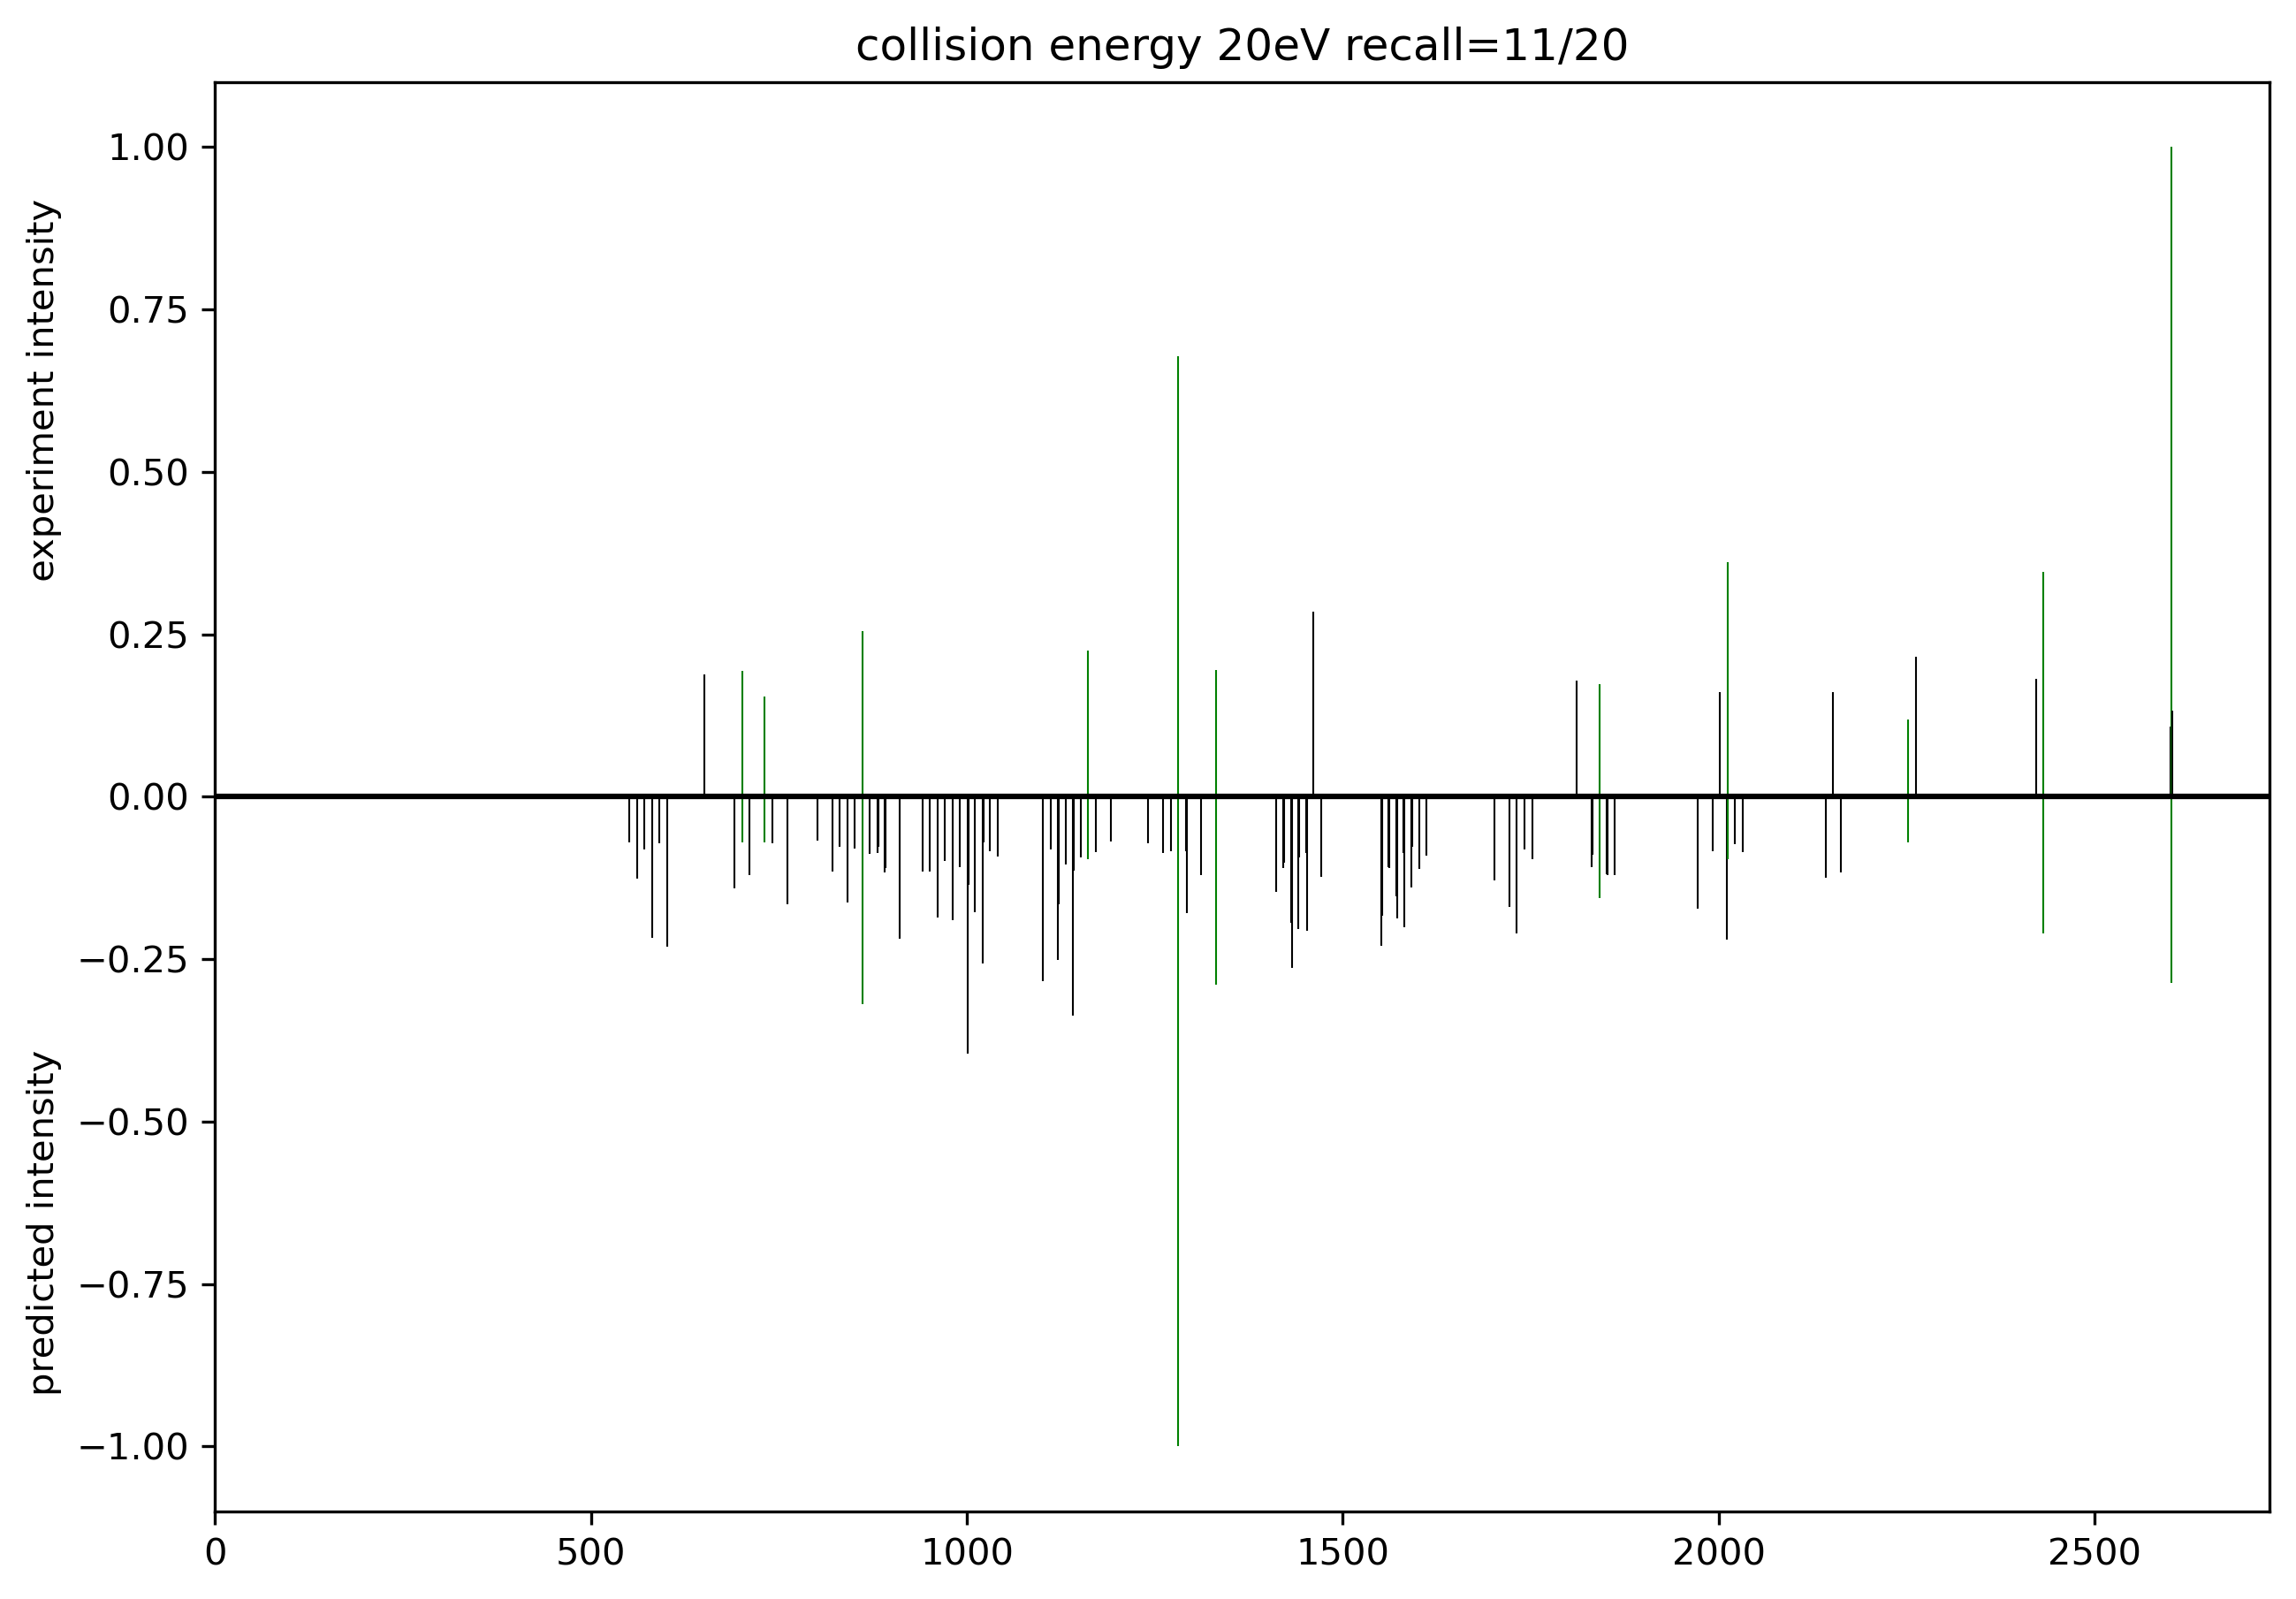

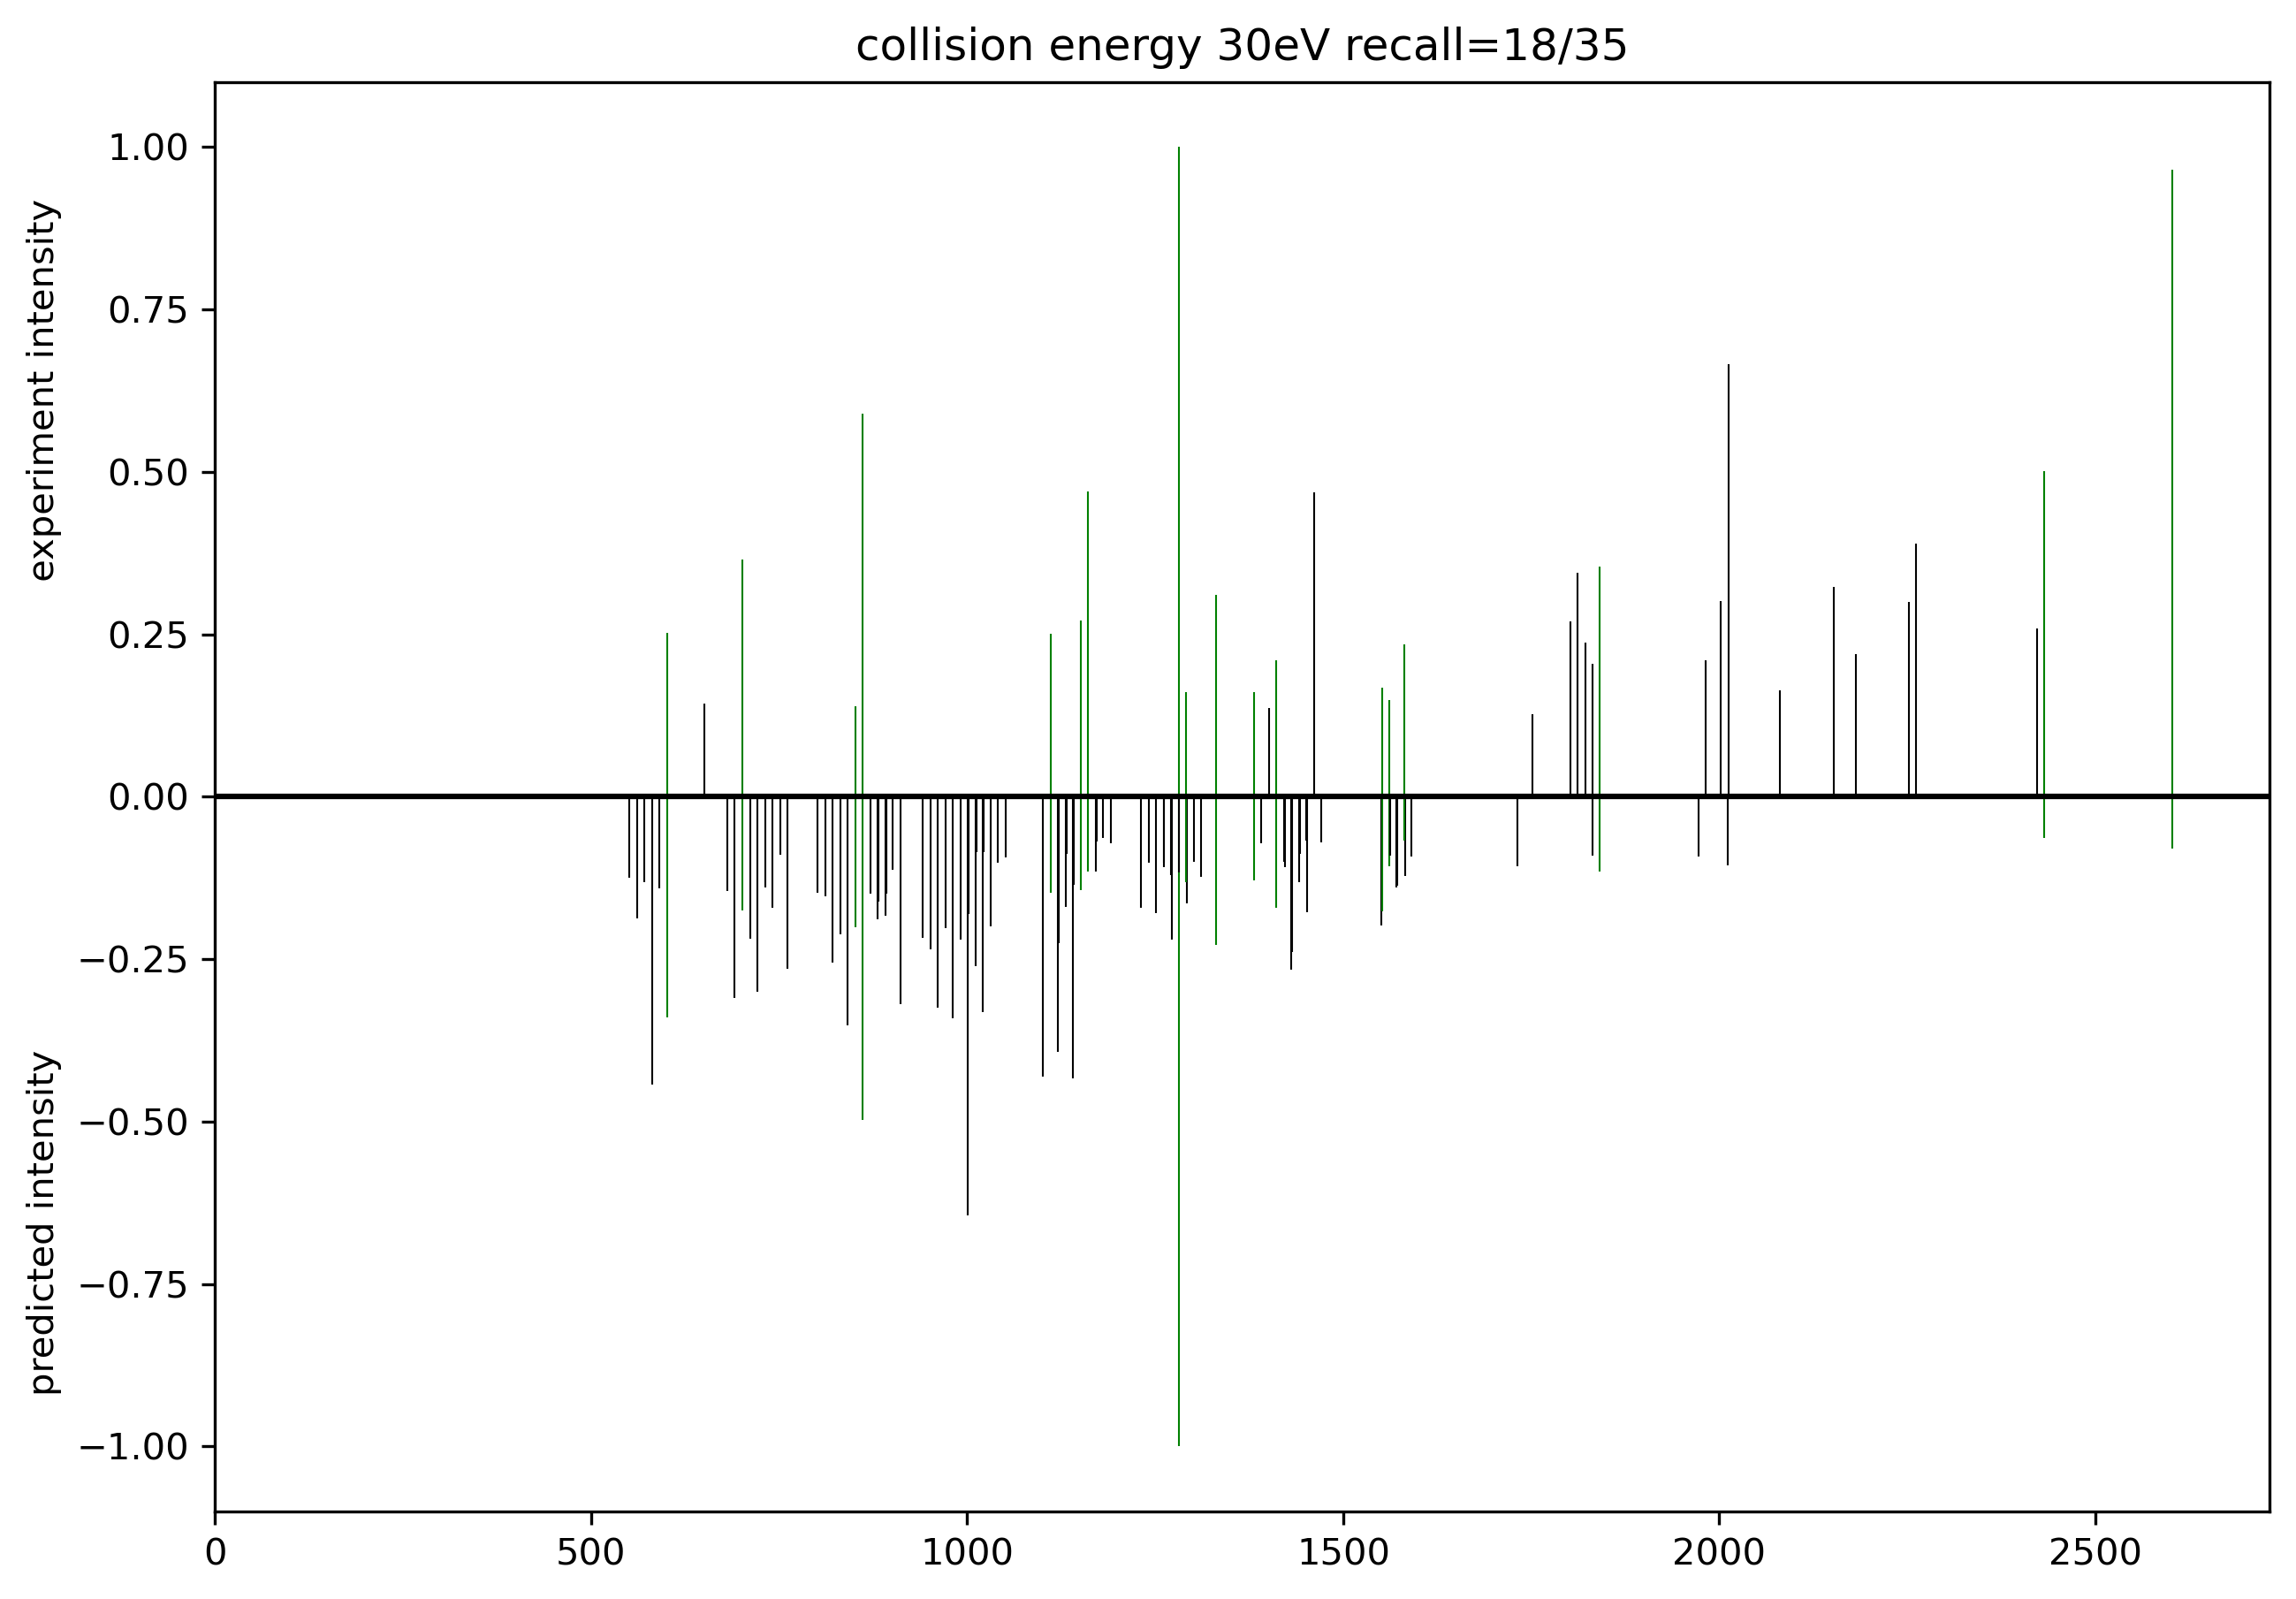

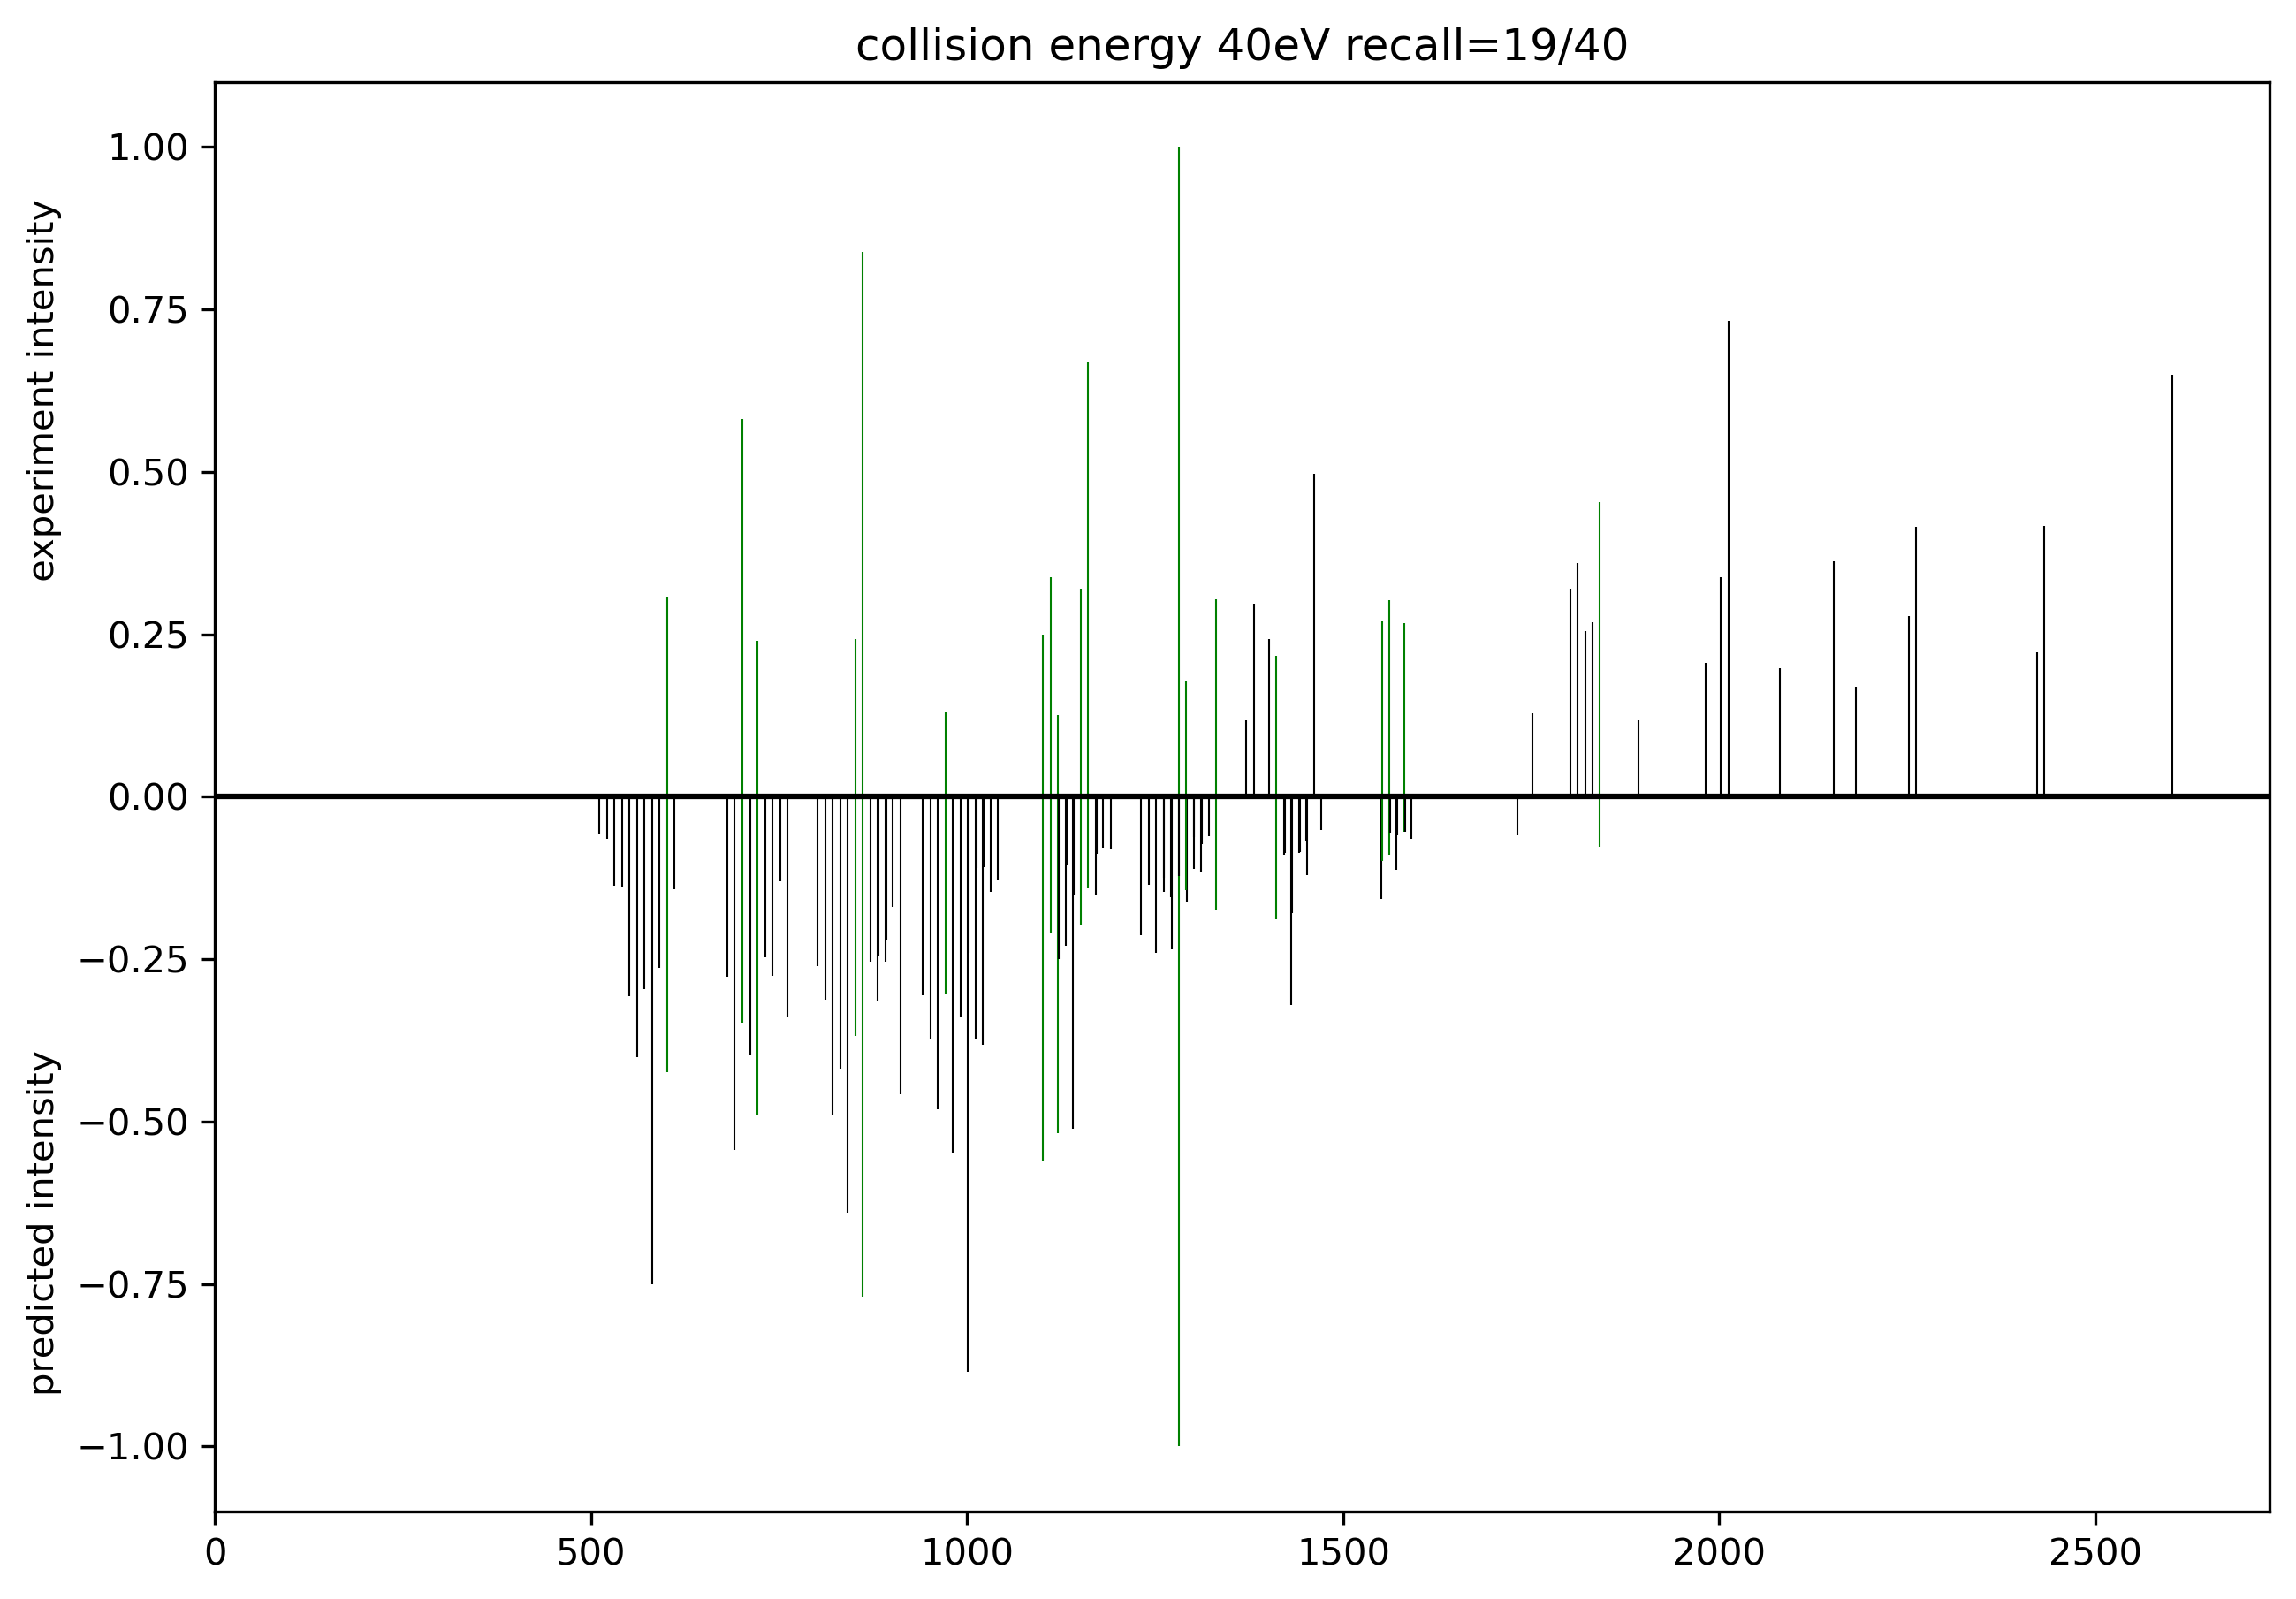

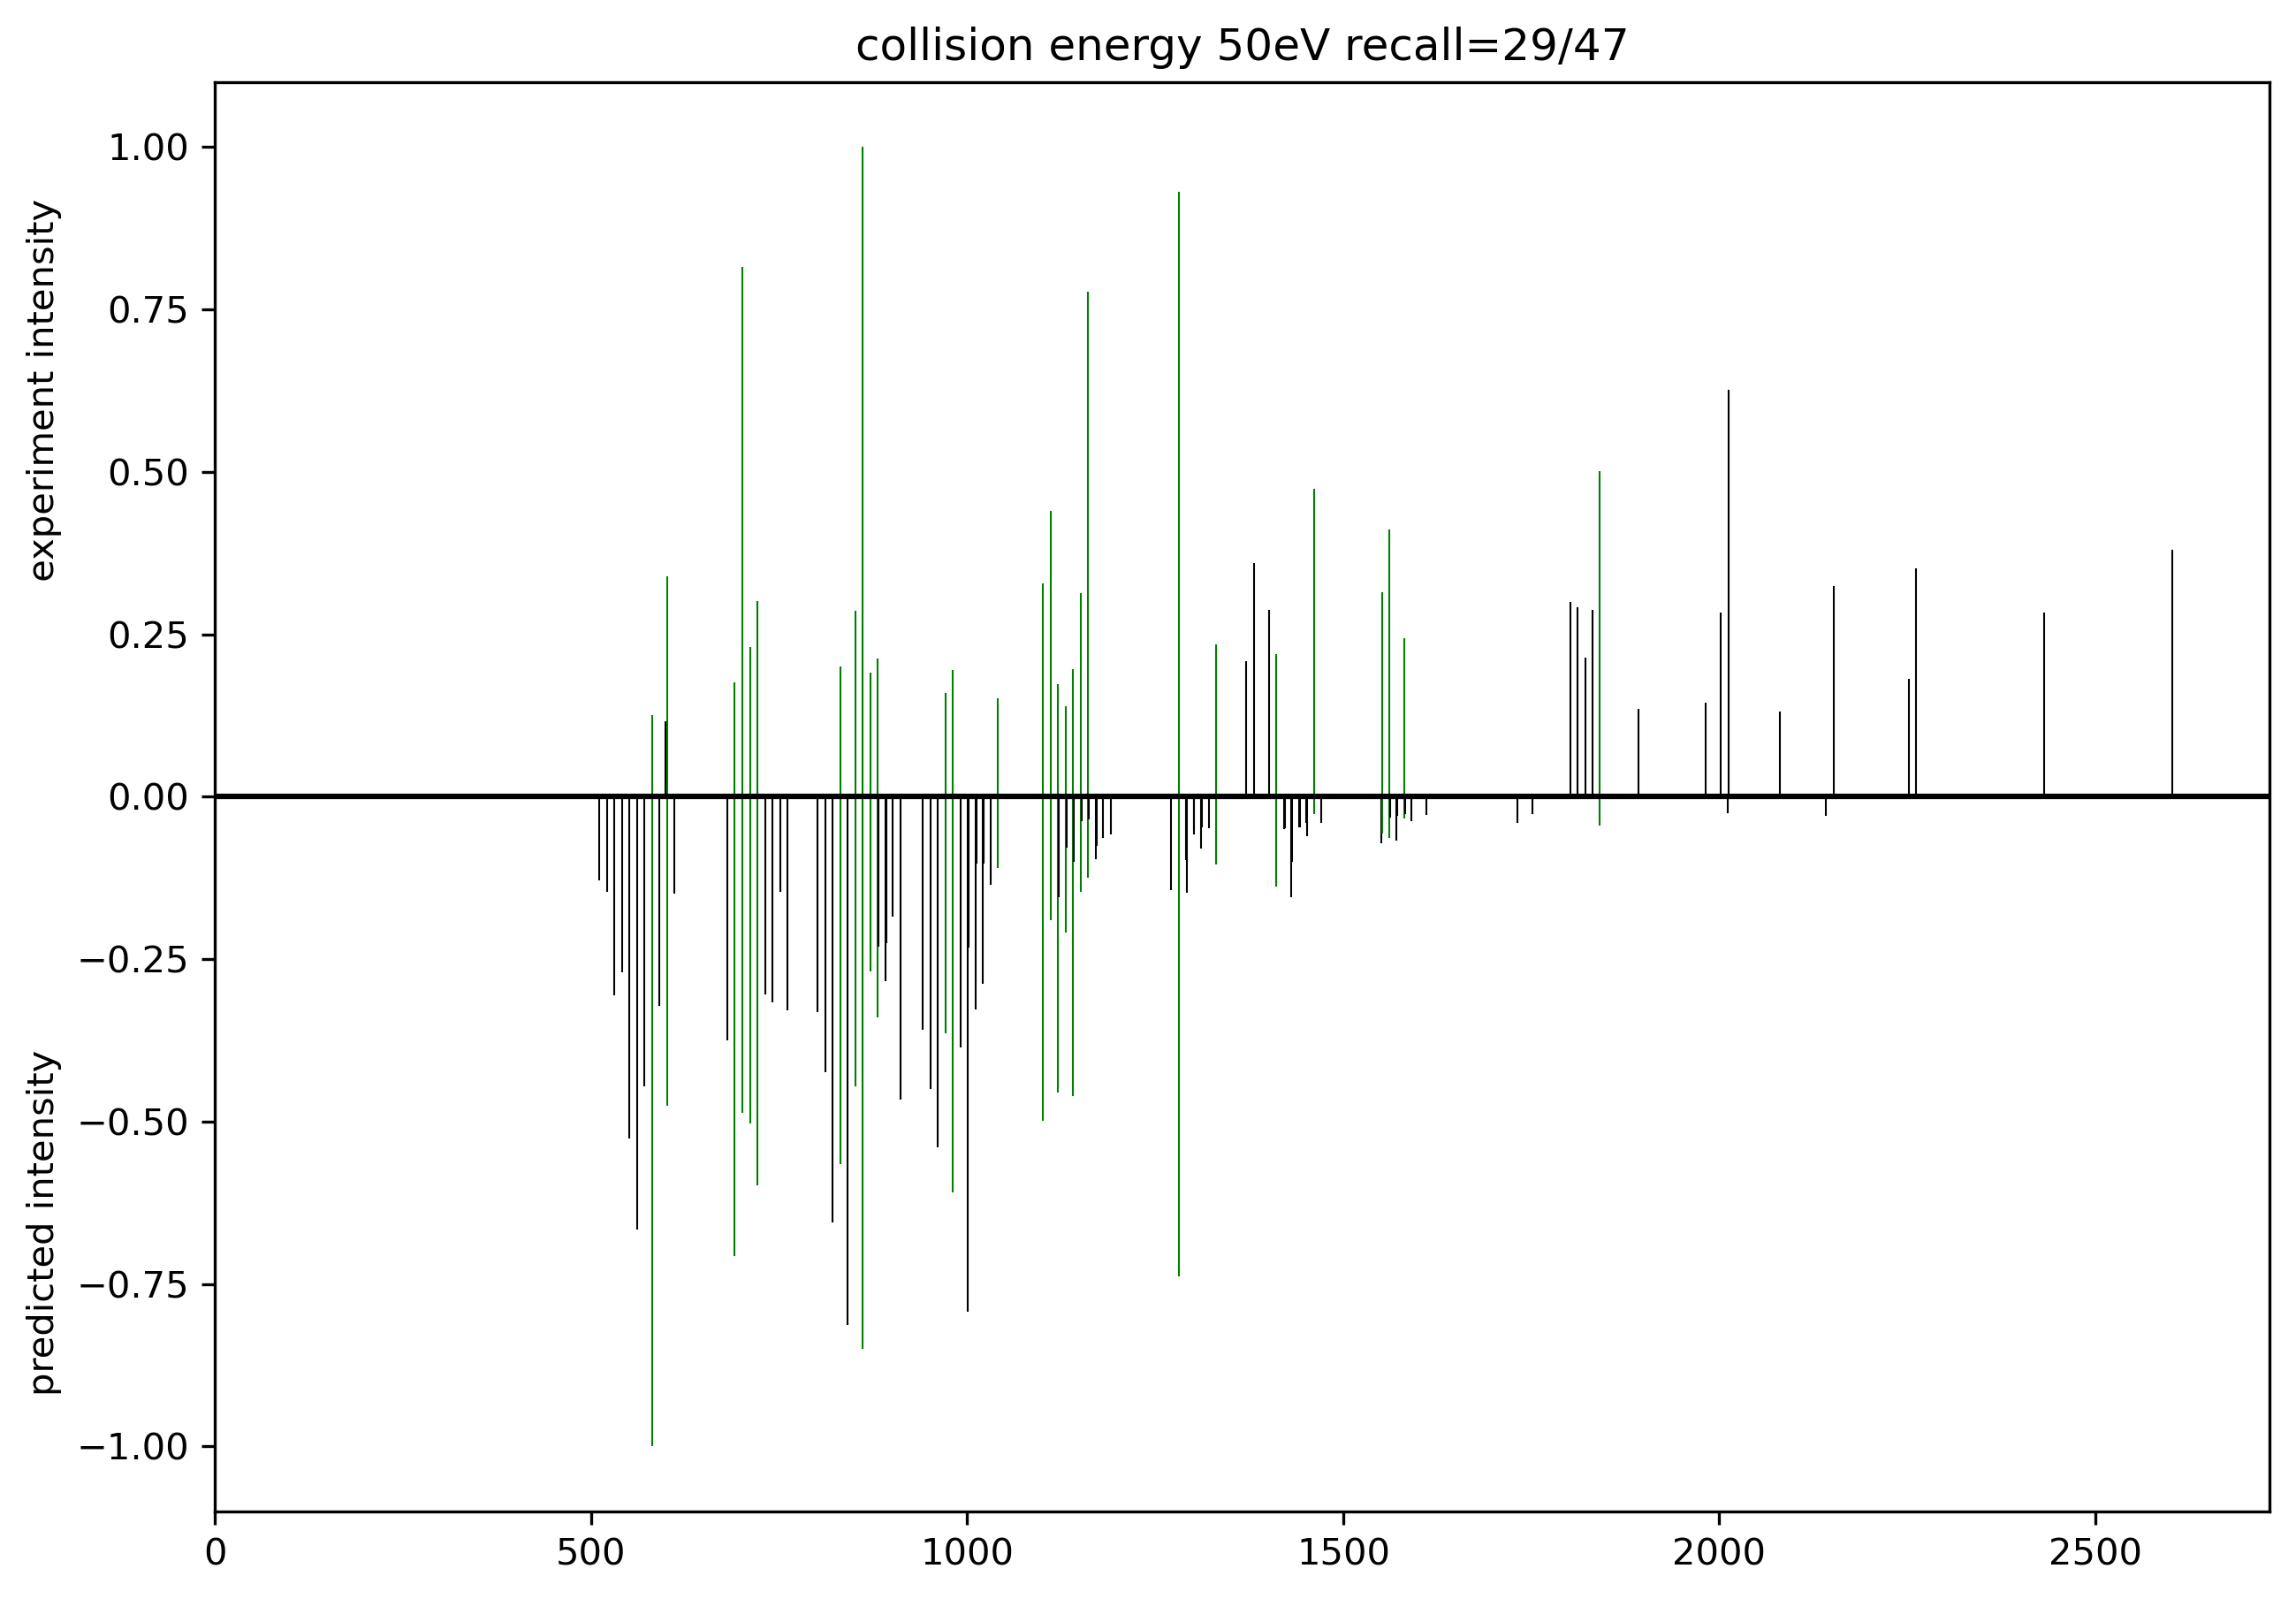

In [12]:
num_recall = 0
for ce in ref_binned.keys():
    ref_binned_sparse = np.vstack((np.where(ref_binned[ce] != 0), ref_binned[ce][np.where(ref_binned[ce] != 0)])).T
    pred_spec = pred_specs[sorted_indices[0]][ce]
    n_recall = np.sum(ref_binned_sparse[:, 0][:, None] == pred_spec[:, 0][None, :])
    num_recall += n_recall
    common.plot_compare_ms(ref_binned_sparse, pred_spec, 'experiment', 'predicted',  f'collision energy {ce}eV recall={n_recall}/{ref_binned_sparse.shape[0]}')
print(f'num recall = {num_recall}')


In [ ]:
dist = []
for precursor, adduct, real_spec_name in [(471.3469, '[M+H-H2O]+', 'cmpd7_471_3467'), (511.3394, '[M+Na]+', 'cmpd7_511_3392')]:
    for name_suffix in ('1', '2'):
        spec_df = pd.read_csv(real_spec_dir / f'{real_spec_name}_{name_suffix}.csv', header=7)
        ref_spec = common.process_spec_file({'parentmass': precursor}, [('30', np.array(spec_df))], merge_specs=False)
        ref_spec = {k: common.max_inten_spec(v, max_num_inten=500, inten_thresh=0.001) for k, v in ref_spec.items()}
        ref_binned = {k: common.bin_spectra([v], num_bins)[0] for k, v in ref_spec.items()}

        select = spec_names == real_spec_name
        cand_smi = smiles[select]
        cand_specs = pred_specs[select]
        dist.append(cos_dist(cand_specs, ref_binned))
        
        # binned_sparse_ref = np.vstack((np.where(ref_binned['30'] != 0), ref_binned['30'][np.where(ref_binned['30'] != 0)])).T
        # plot_compare_ms(binned_sparse_ref, cand_specs[24]['30'])

dist = np.array(dist)

In [ ]:
result_path = '/home/runzhong/ms-pred/results/dag_inten_nist20/split_1_rnd1/elucidation_broad_distress/ranked_smiles.tsv'
df_result = pd.read_csv(result_path, sep='\t')
df_result

In [ ]:
label_path = '/home/runzhong/broad_ms_share/distress/HILIC-pos/HILIC-pos_mapping_MSMS.csv'
df_label = pd.read_csv(label_path, sep=',')
df_label = df_label[df_label["Metabolite"].notnull() | df_label["Of Interest"] == True]
df_label

# Validation on known Metabolites 

In [ ]:
max_topk = 1000

val_result = {}
for row in df_label[df_label["Metabolite"].notnull()].iterrows():
    comp_id = row[1]['Compound_ID']
    target = row[1]["Metabolite"]
    df_sub_result = df_result[df_result['spec_name'] == comp_id]
    
    compounds = pcp.get_compounds(target, 'name')
    if len(compounds) == 0:
        print(f'No match in PubChem for {comp_id}')
        target_mol = target_inchikey = None
    else:
        target_mol = [Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(comp.isomeric_smiles), isomericSmiles=False)) for comp in compounds]
        target_inchikey = [Chem.MolToInchiKey(mol) for mol in target_mol]

    mol_list = []
    dist_list = []
    real_idx = -1
    for idx, sub_row in enumerate(df_sub_result.iterrows()):
        if len(mol_list) >= max_topk:
            if real_idx < 0:
                print(f'Real compound not found in Top{max_topk} for {comp_id} (total={df_sub_result.shape[0]})')
            break
        mol = Chem.MolFromSmiles(sub_row[1]["predict_smiles"])
        if target_inchikey is not None and Chem.MolToInchiKey(mol) in target_inchikey:
            print(f'Real compound found at index {idx}/{df_sub_result.shape[0]} for {comp_id}') # not likely to happen
            real_idx = idx
        mol_list.append(mol)
        dist_list.append(sub_row[1]["cosine_distance"])
    val_result[comp_id] = {'target': target, 'target_mol': target_mol, 'mol_list': mol_list, 'dist_list': dist_list, 'real_idx': real_idx}
    

In [ ]:
comp_id = 'QI6186'

obj = val_result[comp_id]
print(f'Target Metabolite is {obj["target"]}')
print(f"Real distance={obj['dist_list'][obj['real_idx']]}")
Draw.MolsToGridImage(obj["target_mol"], molsPerRow=5, subImgSize=(250,250), legends=[f"target mass={ExactMolWt(m):.3f} \nInchikey={Chem.MolToInchiKey(m)}" for m in obj["target_mol"]])


In [ ]:
sub_indices = slice(0, 50)
legends = []
for idx, (d, m) in enumerate(zip(obj["dist_list"], obj["mol_list"])):
    legend = f"cos_dis={d:.3f} mass={ExactMolWt(m):.3f}"
    if idx == obj["real_idx"]:
        legend += "\nreal compound"
    legends.append(legend)
Draw.MolsToGridImage(obj["mol_list"][sub_indices], molsPerRow=5, subImgSize=(250,250), legends=legends[sub_indices])